# Imports

In [1]:
import warnings
import numpy              as np
import pandas             as pd
import seaborn            as sns
import matplotlib.pyplot  as plt
import matplotlib.patches as patches
from statsmodels.tsa.arima.model        import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble                   import RandomForestRegressor
from sklearn.linear_model               import LassoCV, LinearRegression, RidgeCV
from sklearn.metrics                    import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection            import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing              import OneHotEncoder, StandardScaler


In [2]:
warnings.filterwarnings("ignore", message="X does not have valid feature names")                                                                                  #Suppress specific warning from sklearn about feature names
warnings.filterwarnings("ignore", category=FutureWarning, message=r"Downcasting object dtype arrays on .*")                                                       #Silence pandas future warning raised in cell 10

# Importing CSV dataset 

In [3]:
ocean_dataset = pd.read_csv("realistic_ocean_climate_dataset.csv", encoding="utf-8-sig")  #Load dataset

print(f"Unclean: {[repr(col) for col in ocean_dataset.columns]}")                         #Print column names with quotes to see leading/trailingwhitespace (if any)
ocean_dataset.columns = ocean_dataset.columns.str.strip()                                 #Remove leading/trailing spaces from column names
print(f"Cleaned: {[repr(col) for col in ocean_dataset.columns]}")                         #Reprint column names to confirm whitespace removed
print(f"\nColumns {ocean_dataset.columns}")                                               #Print column names (have already seen these, but this is a 'native' view)

print("\nHead:")                                                                          #Head header
with pd.option_context("display.max_columns", None, "display.width", 200):                #Temporarily set options to display all columns
    print(ocean_dataset.head())                                                           #  Print full head with all columns visible
#                                                                                         #End of temporary option context

print("\nInfo:")                                                                          #Info header
print(ocean_dataset.info())                                                               #Summary of dataset (cannot embed in f-string when implemented in an ipynb)

nan_summary = (ocean_dataset.isna().sum().rename("NaN Count").to_frame())                 #Count NaNs by column
nan_summary["NaN %"] = (nan_summary["NaN Count"] / len(ocean_dataset) * 100).round(2)     #Calculate NaN percentage
print("\nNaN summary by column:")                                                         #Begin NaN summary printout
print(nan_summary.sort_values("NaN Count", ascending=False))                              #Print NaN summary sorted by count

print("\nDate check:")                                                                    #Begin Date column check
print("  This is important because Date will become the working set index")               #Explain purpose of Date check
print(f"  Index name: {ocean_dataset.index.name}")                                        #Confirm that no index yet exists
if ("Date") in ocean_dataset.columns:                                                     #Check for existence of 'Date' column
    print("  Column 'Date' does exist.")                                                  #  Date column found
else:                                                                                     #otherwise
    print("  Column 'Date' does not exist.")                                              #  Date column missing (whoops!)
#                                                                                         #End of Date check

Unclean: ["'Date'", "'Location'", "'Latitude'", "'Longitude'", "'SST (°C)'", "'pH Level'", "'Bleaching Severity'", "'Species Observed'", "'Marine Heatwave'"]
Cleaned: ["'Date'", "'Location'", "'Latitude'", "'Longitude'", "'SST (°C)'", "'pH Level'", "'Bleaching Severity'", "'Species Observed'", "'Marine Heatwave'"]

Columns Index(['Date', 'Location', 'Latitude', 'Longitude', 'SST (°C)', 'pH Level',
       'Bleaching Severity', 'Species Observed', 'Marine Heatwave'],
      dtype='object')

Head:
         Date            Location  Latitude  Longitude  SST (°C)  pH Level Bleaching Severity  Species Observed  Marine Heatwave
0  2015-01-01             Red Sea   20.0248    38.4931     29.47     8.107                NaN               106            False
1  2015-01-07  Great Barrier Reef  -18.2988   147.7782     29.65     8.004               High               116            False
2  2015-01-14       Caribbean Sea   14.9768   -75.0233     28.86     7.947               High                90   

# Encoding

## Ordinal Encoding

In [4]:
ocean_dataset['Bleaching Severity'] = ocean_dataset['Bleaching Severity'].fillna('None')                                  #Treat missing entries as the "no bleaching" category so they safely map to 0

severity_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}                                                              #Preserve the ordinal ranking for downstream models and stats
heatwave_map = {False: 0, True: 1, 'FALSE': 0, 'TRUE': 1}                                                                 #Normalise boolean strings/flags into a consistent binary encoding

ocean_dataset['Bleaching Severity Encoded'] = ocean_dataset['Bleaching Severity'].map(severity_map)                       #Produce numeric labels consumed by sklearn
ocean_dataset['Marine Heatwave Encoded'] = ocean_dataset['Marine Heatwave'].map(heatwave_map)                             #Ensure categorical heatwave values become model-friendly ints

ocean_dataset[['Bleaching Severity', 'Bleaching Severity Encoded', 'Marine Heatwave', 'Marine Heatwave Encoded']].head()  #Sanity check the transformed columns


,Bleaching Severity,Bleaching Severity Encoded,Marine Heatwave,Marine Heatwave Encoded
0,None,0,False,0
1,High,3,False,0
2,High,3,False,0
3,Medium,2,False,0
4,None,0,False,0


## To Datetime

In [5]:
working_copy = ocean_dataset.copy()                                                                          #Create working copy of dataset (to avoid modifying original, so it's available for later use if needed)

print("Index is", ocean_dataset.index.name)                                                                  #Confirm that no index yet exists (should be None; trying to overwrite it would raise an error)
if "Date" in working_copy.columns:                                                                           #Check for existence of 'Date' column
    working_copy["Date"] = pd.to_datetime(working_copy["Date"])                                              #  Convert 'Date' column to datetime format
    working_copy = working_copy.sort_values("Date").set_index("Date")                                        #  Set 'Date' column as index after sorting
else:                                                                                                        #otherwise
    print("Column 'Date' does not exist; cannot set as index.")                                              #  'Date' column missing (whoops!)
    exit()                                                                                                   #  Bail
#                                                                                                            #End 'Date' column check
print("Index name:", working_copy.index.name)                                                                #Visual check of index name (should be 'Date')

working_copy = working_copy.asfreq("7D").ffill().infer_objects()                                             ##Original: Assumes the Date column is already the index, then asks pandas to ensure an exact 7‑day frequency

print("\nInfo:")                                                                                             #Info header
print(working_copy.info())                                                                                   #Summary of dataset (cannot embed in f-string when implemented in an ipynb)


Index is None
Index name: Date

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2015-01-01 to 2023-12-28
Freq: 7D
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Location                    470 non-null    object 
 1   Latitude                    470 non-null    float64
 2   Longitude                   470 non-null    float64
 3   SST (°C)                    470 non-null    float64
 4   pH Level                    470 non-null    float64
 5   Bleaching Severity          470 non-null    object 
 6   Species Observed            470 non-null    float64
 7   Marine Heatwave             470 non-null    bool   
 8   Bleaching Severity Encoded  470 non-null    float64
 9   Marine Heatwave Encoded     470 non-null    float64
dtypes: bool(1), float64(7), object(2)
memory usage: 37.2+ KB
None


# Exploratory Data Analysis

## Correlation Heatmap

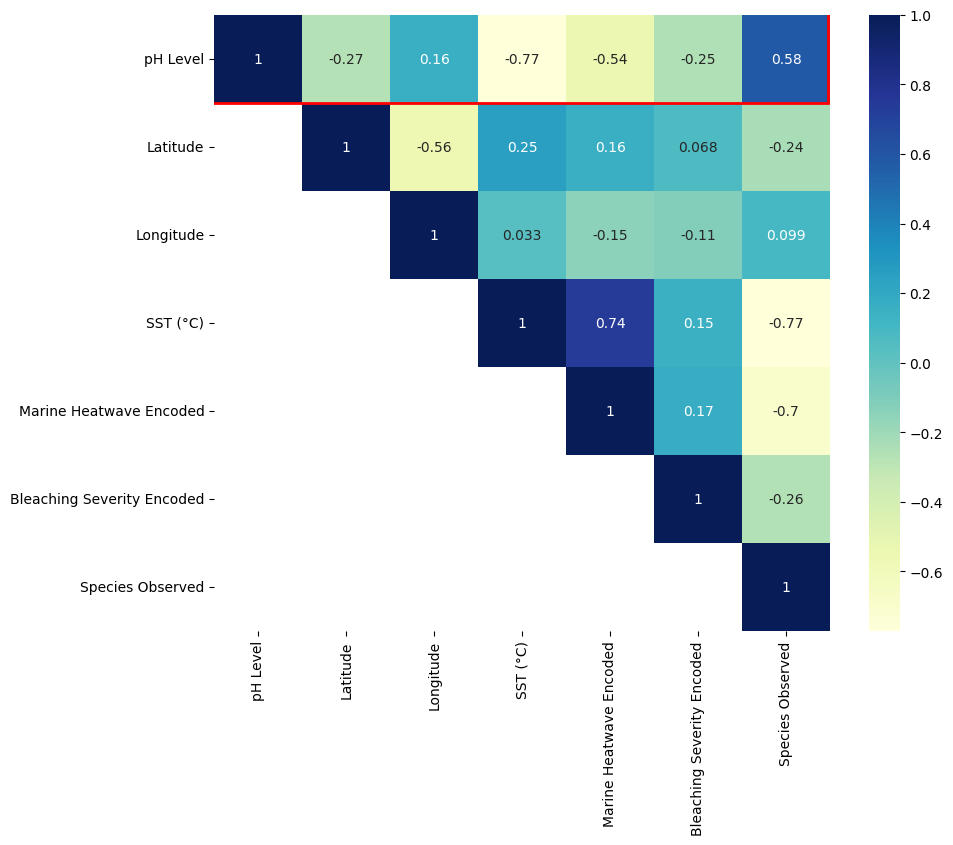

In [6]:
cols_to_use = [                                                   #Columns relevant for correlation matrix
    "pH Level",                                                   #  pH Level
    "Latitude",                                                   #  Latitude
    "Longitude",                                                  #  Longitude
    "SST (°C)",                                                   #  Sea Surface Temperature
    "Marine Heatwave Encoded",                                    #  Marine Heatwave Encoded
    "Bleaching Severity Encoded",                                 #  Bleaching Severity Encoded
    "Species Observed"                                            #  Species Observed
]                                                                 #End column list

filtered_df      = working_copy[cols_to_use]                      #Select only relevant columns for correlation matrix
co_mtx           = filtered_df.corr(numeric_only=True)            #Compute correlation matrix for numeric columns only
cols             = co_mtx.columns.tolist()                        #Get list of columns in correlation matrix
cols.remove("pH Level")                                           #Remove pH Level from list
cols             = ["pH Level"] + cols                            #Reinsert pH Level at the front of the list
co_mtx_reordered = co_mtx.loc[cols, cols]                         #Reorder correlation matrix to place pH Level first

mask = np.tril(np.ones_like(co_mtx_reordered, dtype=bool), k=-1)  #Create mask for lower triangle

plt.figure(figsize=(10, 8))                                       #Set figure size

ax = sns.heatmap(                                                 #Plot correlation matrix with seaborn
    co_mtx_reordered,                                             #  Data source
    mask   = mask,                                                #  Apply mask to lower triangle
    cmap   = "YlGnBu",                                            #  Color map
    annot  = True,                                                #  Annotate cells with correlation values
    square = True,                                                #  Square cells
    cbar   = True                                                 #  Show color bar
)                                                                 #End heatmap plot call

n = co_mtx_reordered.shape[0]                                     #Get number of rows/columns in correlation matrix

rect = patches.Rectangle(                                         #Create rectangle patch to highlight pH Level row/column
    xy        = (-0.5, -0.5),                                     #  Bottom-left corner of rectangle
    width     = n + 0.48,                                         #  Width of rectangle
    height    = 1.5,                                              #  Height of rectangle
    linewidth = 2.0,                                              #  Line width
    edgecolor = "red",                                            #  Red edge color
    facecolor = "none",                                           #  No fill color
)                                                                 #End rectangle patch creation

ax.add_patch(rect)                                                #Add rectangle patch to heatmap
plt.savefig('Correlation_Heatmap.png')

# Autocorrelation Heatmap

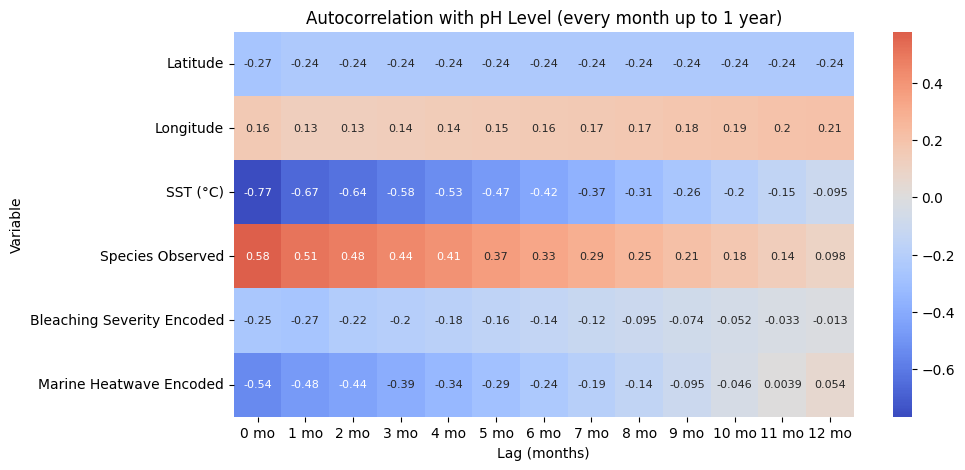

In [7]:
numeric_df = working_copy.select_dtypes(include=[np.number])                                                       #Select only numeric columns for autocorrelation analysis
target     = "pH Level"                                                                                            #Target variable for autocorrelation analysis
max_lag    = 12                                                                                                    #Maximum lag in months for autocorrelation calculation
corrs      = pd.DataFrame(index=numeric_df.columns, columns=[f"{i} mo" for i in range(max_lag + 1)], dtype=float)  #Prepare DataFrame to hold autocorrelations

for var in numeric_df.columns:                                                                                     #Iterate over numeric variables in the dataset
    for lag in range(max_lag + 1):                                                                                 #  Iterate over lag values from 0 to max_lag
        shifted = numeric_df[var].shift(lag)                                                                       #    Shift the variable by the current lag
        corrs.loc[var, f"{lag} mo"] = numeric_df[target].corr(shifted)                                             #    Compute and store the autocorrelation with the target variable
    #                                                                                                              #  Next lag value iteration
#                                                                                                                  #Next variable iteration

corrs = corrs.drop(index=target)                                                                                   #Remove target variable from correlation results

plt.figure(figsize=(10, 5))                                                                                        #Set figure size
sns.heatmap(corrs, annot=True, cmap="coolwarm", center=0, annot_kws={"size": 8})                                   #Plot autocorrelation heatmap (font size reduced to prevent overlapping in Species Observed)
plt.title(f"Autocorrelation with {target} (every month up to 1 year)")                                             #Set plot title
plt.xlabel("Lag (months)")                                                                                         #Set x-axis label
plt.ylabel("Variable")                                                                                             #Set y-axis label
plt.savefig('Autocorrelation_Heatmap.png')
plt.show()                                                                                                         #Display plot


# Pairplot

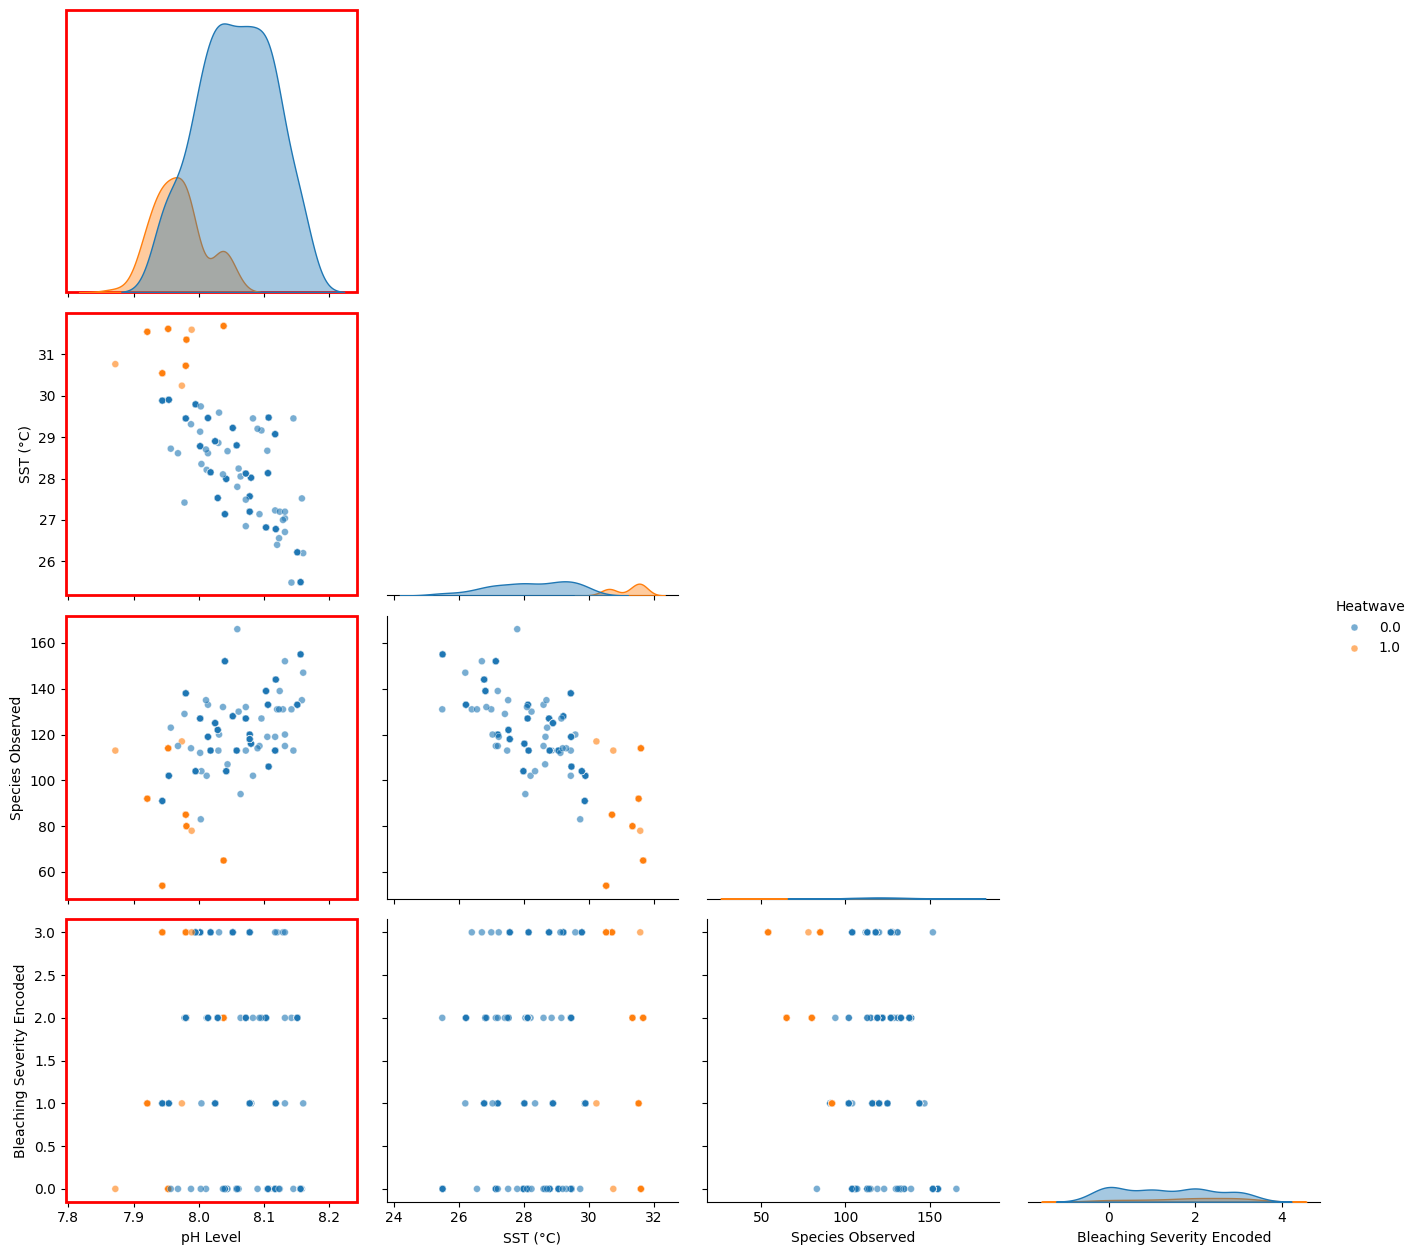

In [8]:
vars_to_plot = [                                              #Variables to include in pair plot
    "pH Level",                                               #  pH Level
    "SST (°C)",                                               #  Sea Surface Temperature
    "Species Observed",                                       #  Species Observed
    "Bleaching Severity Encoded"                              #  Bleaching Severity Encoded
]                                                             #End variable list

g = sns.PairGrid(                                             #Create PairGrid for pair plot
    working_copy,                                             #  Data source
    vars   = vars_to_plot,                                    #  Variables to plot
    hue    = "Marine Heatwave Encoded",                       #  Hue variable for color coding
    corner = True,                                            #  Only show lower triangle
    height = 3.2,                                             #  Set height of each subplot
    aspect = 1.05                                             #  Set aspect ratio of each subplot
)                                                             #End PairGrid creation

g.map_lower(sns.scatterplot, s=25, alpha=0.6)                 #Map scatter plots to lower triangle with slightly larger, semi-transparent markers
g.map_diag(sns.kdeplot, fill=True, bw_adjust=1.2, alpha=0.4)  #Map filled KDE plots to diagonal for clearer marginal densities

for i, y_var in enumerate(g.y_vars):                          #Iterate over y variables
    for j, x_var in enumerate(g.x_vars):                      #  Iterate over x variables
        if i < j: continue                                    #    Skip upper triangle
        ax = g.axes[i, j]                                     #    Get current axis
        if (x_var == "pH Level") or (y_var == "pH Level"):    #    Check if either variable is pH Level
            rect = patches.Rectangle(                         #      Create rectangle patch to highlight pH Level plots
                (0, 0), 1, 1,                                 #        Rectangle spans entire axis
                transform = ax.transAxes,                     #        Use axis coordinates
                linewidth = 2,                                #        Line width
                edgecolor = "red",                            #        Red edge color
                facecolor = "none",                           #        No fill color
                zorder    = 1000,                             #        Ensure rectangle is on top
                clip_on   = False                             #        Disable clipping
            )                                                 #      End rectangle patch creation
            ax.add_patch(rect)                                #      Add rectangle patch to current axis
        #                                                     #    End of pH Level highlight check
    #                                                         #  Next x variable iteration
#                                                             #Next y variable iteration

g.add_legend(title="Heatwave")                                #Add legend to pair plot
plt.savefig('Pairplot.png')
plt.show()                                                    #Display plot


## Linear Regression

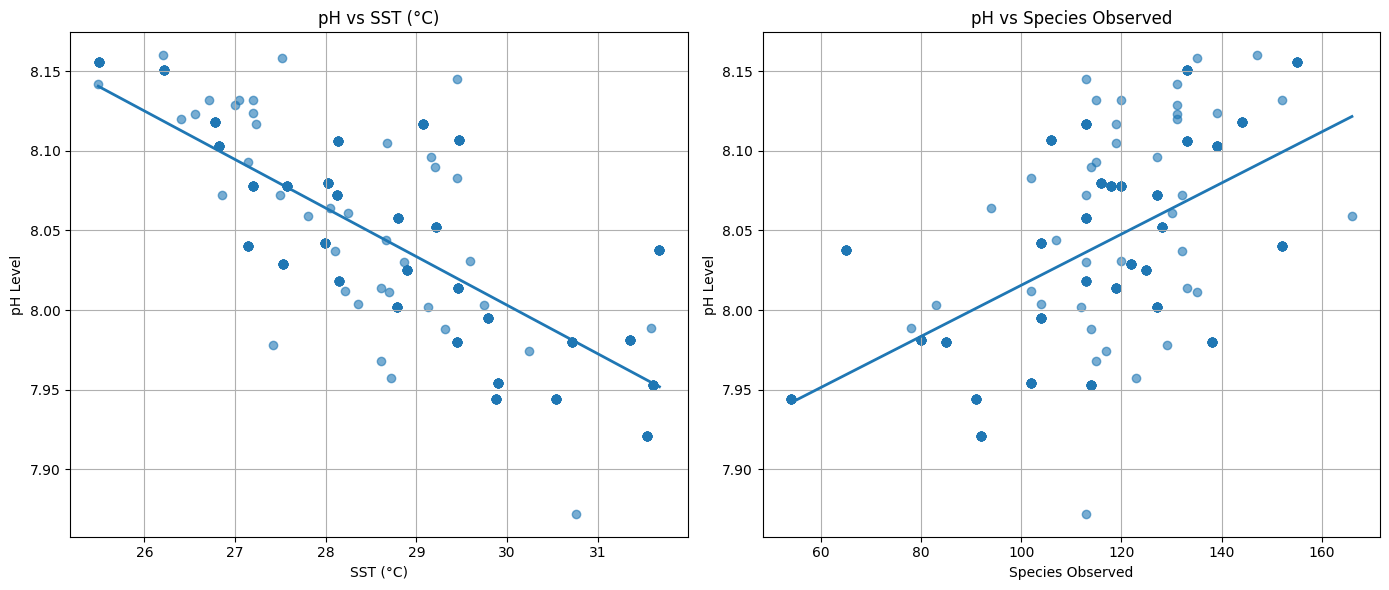

In [9]:
df = working_copy.copy()                                                 #Create copy of working dataset for regression plots
x  = df[['SST (°C)', 'Species Observed']]                                #Define feature matrix
y  = df['pH Level']                                                      #Define target variable

features_to_plot = ['SST (°C)', 'Species Observed']                      #Features to plot against pH Level

fig, axes = plt.subplots(1, 2, figsize=(14, 6))                          #Create figure and axes for side-by-side plots
fig.patch.set_facecolor("white")                                         #Set figure background to white

for ax, feature in zip(axes, features_to_plot):                          #Iterate over features and corresponding axes
    x_var = x[[feature]]                                                 #  Select single feature for x variable
    model = LinearRegression().fit(x_var, y)                             #  Fit linear regression model

    ax.scatter(x_var, y, alpha=0.6)                                      #  Scatter plot of data points

    x_range = np.linspace(x_var.min(), x_var.max(), 100).reshape(-1, 1)  #  Generate range of x values for line
    y_line  = model.predict(x_range)                                     #  Predict corresponding y values
    ax.plot(x_range, y_line, linewidth=2)                                #  Plot regression line

    ax.set_xlabel(feature)                                               #  Set x-axis label
    ax.set_ylabel("pH Level")                                            #  Set y-axis label
    ax.set_title(f"pH vs {feature}")                                     #  Set plot title
    ax.grid(True)                                                        #  Enable grid
#                                                                        #Next feature and axis iteration

plt.tight_layout()                                                       #Adjust layout to prevent overlap
plt.savefig('Linear_Regression.png')
plt.show()                                                               #Display plot

del df, x, y                                                             #Remove temporary regression structures to prevent scope bleed (shouldn't happen, but...)

# -- Model Testing -- 

## LassoCV

Fold 1: RMSE=0.0424, MAE=0.0336, R²=0.3733
Fold 2: RMSE=0.0443, MAE=0.0403, R²=0.6158
Fold 3: RMSE=0.0184, MAE=0.0137, R²=0.7421
Optimal alpha: 0.01000

--- TRAIN METRICS ---
RMSE: 0.0285
MAE: 0.0204
R²: 0.7530

--- VALIDATION METRICS ---
RMSE: 0.0350
MAE : 0.0292
R²  : 0.5770

--- TEST METRICS ---
RMSE: 0.0418
MAE: 0.0314
R²: 0.7541

--- FORECAST METRICS ---
RMSE: 0.0782
MAE: 0.0702

Lasso Coefficients:
SST (°C): -0.0115
Marine Heatwave Encoded: -0.0000
Bleaching Severity Encoded: -0.0000
Species Observed: 0.0000
Latitude: -0.0000
Longitude: -0.0000
pH_lag1: 0.0256
pH_lag2: 0.0070
pH_lag3: 0.0000
pH_lag4: 0.0000
pH_lag5: 0.0000
pH_lag6: 0.0000
pH Level_rollmean_7: 0.0000
pH Level_rollmean_14: 0.0000
month_sin: 0.0000
month_cos: 0.0000


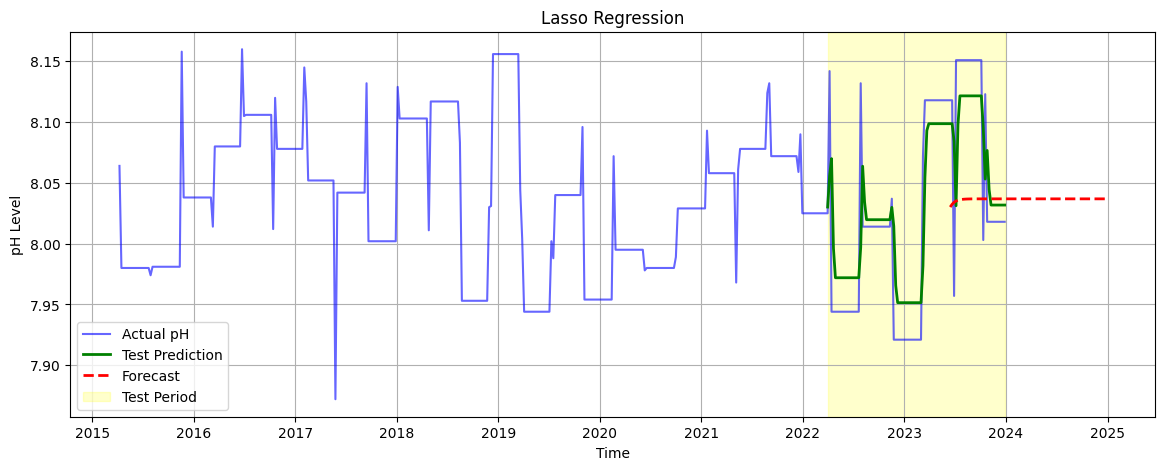

In [10]:
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit

forecast_start_date = pd.to_datetime("2023-06-15")                                                                                                  #Define forecast start date
forecast_end_date   = pd.to_datetime("2024-12-31")                                                                                                  #Define forecast end date
OVERLAP             = 25                                                                                                                            #Overlap length for forecast evaluation
N_SPLITS            = 3                                                                                                                             #Number of splits for Time Series CV
alphas_grid         = [0.001, 0.01, 0.1, 1]                                                                                                         #Alpha grid for LassoCV
ROLL_WINDOWS        = [7, 14]                                                                                                                       #Rolling window sizes
TARGET              = "pH Level"                                                                                                                    #Target is level
MAX_LAG             = 6                                                                                                                             #pH lags


lasso_df = working_copy.copy(deep=True)                                                                                                             #Deep copy of working dataset

for lag in range(1, MAX_LAG + 1):                                                                                                                   #Lag pH levels
    lasso_df[f"pH_lag{lag}"] = lasso_df[TARGET].shift(lag)                                                                                          #  Create lagged pH level features
#                                                                                                                                                   #Next pH lag

for w in ROLL_WINDOWS:                                                                                                                              #Rolling mean of pH
    lasso_df[f"{TARGET}_rollmean_{w}"] = lasso_df[TARGET].rolling(window=w).mean().shift(1)                                                         #  Create rolling mean feature
#                                                                                                                                                   #Next rolling window

if not isinstance(lasso_df.index, pd.DatetimeIndex):                                                                                                #Ensure datetime index for seasonal features
    lasso_df.index = pd.to_datetime(lasso_df.index)                                                                                                 #  Convert index to datetime if not already
#                                                                                                                                                   #End datetime index check

lasso_df['month_sin'] = np.sin(2 * np.pi * lasso_df.index.month / 12)                                                                               #Seasonal features: month as sine and cosine
lasso_df['month_cos'] = np.cos(2 * np.pi * lasso_df.index.month / 12)                                                                               #End seasonal features

lasso_df = lasso_df.dropna()                                                                                                                        #Drop rows with NaN from lags/rolls

lag_features      = [f"pH_lag{lag}" for lag in range(1, MAX_LAG + 1)]                                                                               #Lag features
roll_features     = [f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]                                                                                #Rolling mean features
seasonal_features = ['month_sin', 'month_cos']                                                                                                      #Seasonal features
base_features     = ['SST (°C)', 'Marine Heatwave Encoded', 'Bleaching Severity Encoded', 'Species Observed', 'Latitude', 'Longitude']              #Base features
feature_columns   = base_features + lag_features + roll_features + seasonal_features                                                                #All feature columns

y = lasso_df[TARGET]                                                                                                                                #Target variable (level)
x = lasso_df[feature_columns]                                                                                                                       #Feature matrix

split_idx       = int(len(x) * 0.8)                                                                                                                 #80/20 chronological split
x_train, x_test = x.iloc[:split_idx], x.iloc[split_idx:]                                                                                            #Train/test split
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]                                                                                            #Train/test split

pipe = Pipeline([                                                                                                                                   #Pipeline for scaling and LassoCV
        ('scalar', StandardScaler()),                                                                                                               #  Standard scaler
        ('lasso', Lasso(max_iter=5000, random_state=42))                                                                                            #  LassoCV with specified alphas
        ])                                                                                                                                          #End pipeline definition

lasso_param_grid = {
    'lasso__alpha': alphas_grid
}

tscv                         = TimeSeriesSplit(n_splits=N_SPLITS)                                                                                   #Time Series cross-validator
fold_mae, fold_rmse, fold_r2 = [], [], []                                                                                                           #Lists to hold fold metrics

for fold, (train_idx, val_idx) in enumerate(tscv.split(x_train)):                                                                                   #Iterate over Time Series CV folds
    x_tr, x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]                                                                                    #  Train/validation split for current fold
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]                                                                                    #  Train/validation split for current fold

    fold_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=5000, random_state=42))
    ])                                                                                                                                             #  End pipeline definition for current fold
    
    fold_search = GridSearchCV(
        estimator = fold_pipe,
        param_grid = lasso_param_grid,
        cv = tscv,                            
        scoring = 'neg_mean_squared_error',        
        n_jobs = -1
    )
    
    fold_search.fit(x_tr, y_tr)                                                                                                                     #  Fit pipeline on training data of current fold
    best_fold_pipe = fold_search.best_estimator_
    y_val_pred = best_fold_pipe.predict(x_val)                                                                                                      #  Predict on validation data of current fold
    fold_mae.append(mean_absolute_error(y_val, y_val_pred))                                                                                         #  Compute and store MAE for current fold
    fold_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))                                                                                #  Compute and store RMSE for current fold
    fold_r2.append(r2_score(y_val, y_val_pred))                                                                                                     #  Compute and store R² for current fold

    print(                                                                                                                                          #  Print fold metrics
        f"Fold {fold+1}: "                                                                                                                          #    Fold index
        f"RMSE={fold_rmse[-1]:.4f}, "                                                                                                               #    RMSE
        f"MAE={fold_mae[-1]:.4f}, "                                                                                                                 #    MAE
        f"R²={fold_r2[-1]:.4f}"                                                                                                                     #    R²
    )                                                                                                                                               #  End fold metrics printout
#                                                                                                                                                   #Next fold iteration

final_search = GridSearchCV(
    estimator = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(max_iter=5000, random_state=42))
    ]),
    param_grid = lasso_param_grid,
    cv = tscv,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)

final_search.fit(x_train, y_train)

final_pipe = final_search.best_estimator_                                                                                                                                                                                                                                                                                                                                        #Extract optimal alpha from final Lasso model
best_alpha = final_search.best_params_['lasso__alpha']                                                                                              #Print optimal alpha
print(f"Optimal alpha: {best_alpha:.5f}")

y_train_pred = final_pipe.predict(x_train)                                                                                                          #Predict on training data
y_test_pred  = final_pipe.predict(x_test)                                                                                                           #Predict on test data

def get_metrics(y_true, y_pred):                                                                                                                    #Function to compute regression metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))                                                                                              #  Compute RMSE
    mae  = mean_absolute_error(y_true, y_pred)                                                                                                      #  Compute MAE
    r2   = r2_score(y_true, y_pred)                                                                                                                 #  Compute R²
    return rmse, mae, r2                                                                                                                            #  Return metrics
#                                                                                                                                                   #End get_metrics function

rmse_train, mae_train, r2_train = get_metrics(y_train, y_train_pred)                                                                                #Compute training metrics
rmse_test, mae_test, r2_test    = get_metrics(y_test, y_test_pred)                                                                                  #Compute test metrics

freq = y.index.freq if isinstance(y.index, pd.DatetimeIndex) and y.index.freq else pd.infer_freq(y.index)                                           #Infer frequency from datetime index if possible
if freq is None:                                                                                                                                    #If frequency cannot be inferred
    freq = 'W'                                                                                                                                      #  Default to weekly frequency
#                                                                                                                                                   #End frequency inference

future_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq=freq)                                                           #Create future index for forecasting

pH_history      = list(y_train)                                                                                                                     #Initialise pH history with existing data
last_row        = x_train.iloc[-1].copy()                                                                                                           #Start from last known feature row
recursive_preds = []                                                                                                                                #List to hold recursive predictions

for _ in range(len(future_index)):                                                                                                                  #Iterate over future dates
    for lag in range(1, MAX_LAG + 1):                                                                                                               #  Roll pH lag features forward
        last_row[f"pH_lag{lag}"] = pH_history[-lag]                                                                                                 #    Update lagged pH feature
    #                                                                                                                                               #  Next pH lag feature

    for w in ROLL_WINDOWS:                                                                                                                          #  Update rolling mean features
        window = pH_history[-w:]                                                                                                                    #    Get last w pH values
        last_row[f"{TARGET}_rollmean_{w}"] = np.mean(window)                                                                                        #    Compute and update rolling mean
    #                                                                                                                                               #  Next rolling window feature

    x_next = pd.DataFrame([last_row], columns=x.columns)                                                                                            #  Create DataFrame for next prediction
    y_next = final_pipe.predict(x_next)[0]                                                                                                          #  Predict next pH value

    recursive_preds.append(y_next)                                                                                                                  #  Store recursive prediction
    pH_history.append(y_next)                                                                                                                       #  Append prediction to pH history for next iteration
    last_row = x_next.iloc[0].copy()                                                                                                                #  Update last_row for next iteration
#                                                                                                                                                   #Next future date iteration

y_forecast_series = pd.Series(recursive_preds, index=future_index)                                                                                  #Create Series for forecasted pH values

if OVERLAP > 0:                                                                                                                                     #If overlap evaluation is desired
    y_overlap          = y_test[:OVERLAP]                                                                                                           #  Get actual pH values for overlap period
    y_forecast_overlap = y_forecast_series.iloc[:OVERLAP]                                                                                           #  Get forecasted pH values for overlap period
    rmse_forecast      = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))                                                                 #  Calculate RMSE for overlap period
    mae_forecast       = mean_absolute_error(y_overlap, y_forecast_overlap)                                                                         #  Calculate MAE for overlap period
else:                                                                                                                                               #otherwise
    rmse_forecast = mae_forecast = np.nan                                                                                                           #  Set forecast metrics to NaN
#                                                                                                                                                   #End overlap evaluation check

print("\n--- TRAIN METRICS ---")                                                                                                                    #Print training metrics
print(f"RMSE: {rmse_train:.4f}")                                                                                                                    #Print RMSE
print(f"MAE: {mae_train:.4f}")                                                                                                                      #Print MAE
print(f"R²: {r2_train:.4f}")                                                                                                                        #Print R²

print("\n--- VALIDATION METRICS ---")                                                                                                               #Print validation metrics
print(f"RMSE: {np.mean(fold_rmse):.4f}")                                                                                                            #Print RMSE
print(f"MAE : {np.mean(fold_mae):.4f}")                                                                                                             #Print MAE
print(f"R²  : {np.mean(fold_r2):.4f}")                                                                                                              #Print R²

print("\n--- TEST METRICS ---")                                                                                                                     #Print test metrics
print(f"RMSE: {rmse_test:.4f}")                                                                                                                     #Print RMSE
print(f"MAE: {mae_test:.4f}")                                                                                                                       #Print MAE
print(f"R²: {r2_test:.4f}")                                                                                                                         #Print R²

if OVERLAP > 0:                                                                                                                                     #If overlap evaluation was performed
    print("\n--- FORECAST METRICS ---")                                                                                                             #  Print forecast metrics
    print(f"RMSE: {rmse_forecast:.4f}")                                                                                                             #  Print RMSE
    print(f"MAE: {mae_forecast:.4f}")                                                                                                               #  Print MAE
#                                                                                                                                                   #End forecast metrics printout

print("\nLasso Coefficients:")                                                                                                                      #Print Lasso coefficients
for name, coef in zip(x.columns, final_pipe.named_steps['lasso'].coef_):                                                                            #Iterate over feature names and coefficients
    print(f"{name}: {coef:.4f}")                                                                                                                    #  Print feature name and coefficient
#                                                                                                                                                   #Next feature iteration

plt.figure(figsize=(14,5))                                                                                                                          #Set figure size
plt.plot(y, label="Actual pH", alpha=0.6, color='blue')                                                                                             #Plot actual pH levels
plt.plot(y_test.index, y_test_pred, label="Test Prediction", linewidth=2, color='green')                                                            #Plot test predictions
plt.plot(y_forecast_series.index, y_forecast_series.values, linestyle='--', color='red', linewidth=2, label="Forecast")                             #Plot forecasted pH levels
plt.axvspan(y_test.index[0], y_test.index[-1], color="yellow", alpha=0.2, label="Test Period")                                                      #Highlight test period
plt.title("Lasso Regression")                                                                                                 #Set plot title
plt.xlabel("Time")                                                                                                                                  #Set x-axis label
plt.ylabel("pH Level")                                                                                                                              #Set y-axis label
plt.grid(True)                                                                                                                                      #Enable grid
plt.legend()                                                                                                                                        #Add legend
plt.savefig('Lasso.png')
plt.show()                                                                                                                                          #Display plot


del x, y, x_test, x_train, y_train, y_test, final_pipe, fold_pipe, y_forecast_series, future_index

## RidgeCV

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fold 1: Optimal alpha=1.0000, RMSE=0.0396, MAE=0.0282, R²=0.4532
Fold 2: Optimal alpha=1.0000, RMSE=0.0593, MAE=0.0517, R²=0.3120
Fold 3: Optimal alpha=1.0000, RMSE=0.0269, MAE=0.0210, R²=0.4477

Optimal alpha on full training set: 1.0000

--- TRAIN METRICS ---
RMSE: 0.0232
MAE : 0.0154
R²  : 0.8272

--- VALIDATION METRICS ---
RMSE: 0.0419
MAE : 0.0337
R² : 0.4043

--- TEST METRICS ---
RMSE: 0.0364
MAE:  0.0239
R²:   0.8140

--- FORECAST METRICS ---
RMSE: 0.0815
MAE: 0.0737

Ridge Coefficients:
SST (°C): -0.0270
Marine Heatwave Encoded: 0.0073
Bleaching Severity Encoded: -0.0018
Species Observed: -0.0043
Latitude: -0.0036
Longitude: 0.0017
pH_lag1: 0.0248
pH_lag2: 0.0093
pH_lag3: 0.0016
pH_lag4: -0.0003
pH_lag5: -0.0004
pH_lag6: -0.0003
pH Level_rollmean_7: 0.0060
pH Level_rollmean_14: -0.0058
month_sin: 0.0025
month_cos: -0.0010


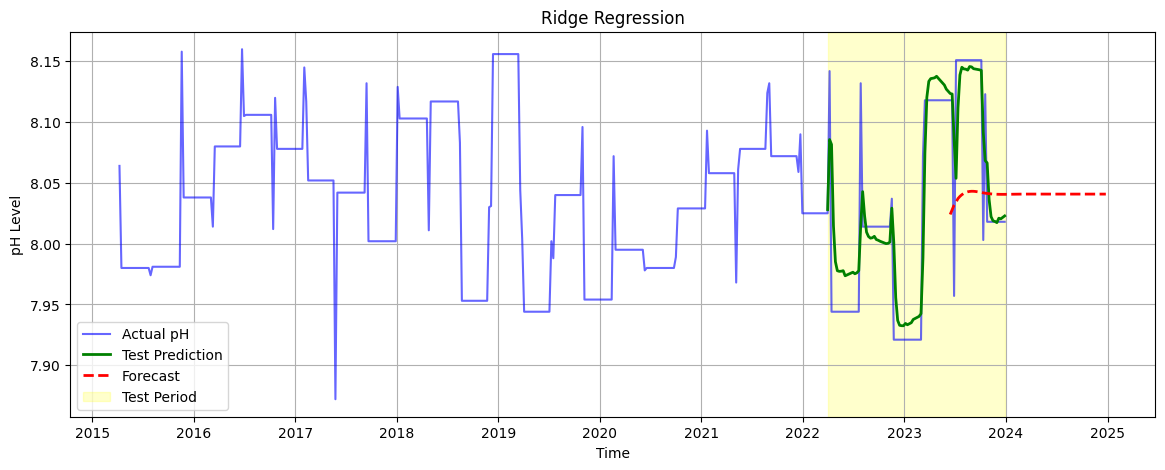

In [11]:
from sklearn.linear_model import Ridge                                                                                                              #Import Ridge regression model
from sklearn.pipeline     import Pipeline                                                                                                           #Import Pipeline for model pipeline

forecast_start_date = pd.to_datetime("2023-06-15")                                                                                                  #Define forecast start date
forecast_end_date   = pd.to_datetime("2024-12-31")                                                                                                  #Define forecast end date
OVERLAP             = 25                                                                                                                            #Define overlap period
ROLL_WINDOWS        = [7, 14]                                                                                                                       #Define rolling window sizes for rolling mean features
TARGET              = "pH Level"                                                                                                                    #Define target variable name
N_SPLITS            = 3                                                                                                                             #Define number of splits for Time Series CV
alpha_grid          = [0.0001, 0.001, 0.01, 0.1, 1]                                                                                                 #Define grid of alpha values for Ridge regression
MAX_LAG             = 6                                                                                                                             #pH lags 

ridge_df = working_copy.copy(deep=True)                                                                                                             #Create deep copy of working dataset for Ridge regression

for lag in range(1, MAX_LAG + 1):                                                                                                                   #Iterate over lag pH levels
    ridge_df[f"pH_lag{lag}"] = ridge_df[TARGET].shift(lag)                                                                                          #  Create lagged pH level features
#                                                                                                                                                   #Next pH lag


for w in ROLL_WINDOWS:                                                                                                                              #Rolling mean feature
    ridge_df[f"{TARGET}_rollmean_{w}"] = ridge_df[TARGET].rolling(window=w).mean().shift(1)                                                         #  Create rolling mean feature with lag
#                                                                                                                                                   #Next rolling window

if not isinstance(ridge_df.index, pd.DatetimeIndex):                                                                                                #Ensure datetime index for seasonal features
    ridge_df.index = pd.to_datetime(ridge_df.index)
ridge_df['month_sin'] = np.sin(2 * np.pi * ridge_df.index.month / 12)                                                                               #Seasonal sine
ridge_df['month_cos'] = np.cos(2 * np.pi * ridge_df.index.month / 12)                                                                               #Seasonal cosine

ridge_df = ridge_df.dropna()                                                                                                                        #Drop rows with NaN values resulting from lagging and rolling operations

lag_features      = [f"pH_lag{lag}" for lag in range(1, MAX_LAG + 1)]                                                                               #List of lag feature names
roll_features     = [f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]                                                                                #List of rolling mean feature names
seasonal_features = ['month_sin', 'month_cos']                                                                                                      #Seasonal features
base_features     = ['SST (°C)', 'Marine Heatwave Encoded', 'Bleaching Severity Encoded', 'Species Observed', 'Latitude', 'Longitude']              #Base features
feature_columns   = base_features + lag_features + roll_features + seasonal_features                                                                #All feature columns

y = ridge_df[TARGET]                                                                                                                                #Target variable
x = ridge_df[feature_columns]                                                                                                                       #Feature matrix

split_idx       = int(len(x) * 0.8)                                                                                                                 #80/20 chronological split
x_train, x_test = x.iloc[:split_idx], x.iloc[split_idx:]                                                                                            #Split features
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]                                                                                            #Split target variable

tscv = TimeSeriesSplit(n_splits=N_SPLITS)                                                                                                           #Initialise TimeSeriesSplit

pipe = Pipeline([                                                                                                                                   #Initialise pipeline
    ('scaler', StandardScaler()),                                                                                                                   #  StandardScaler for feature scaling
    ('ridge',  Ridge())                                                                                                                             #  Ridge regression model
])                                                                                                                                                  #End pipeline initialization

param_grid = {'ridge__alpha': alpha_grid}                                                                                                           #Define hyperparameter grid for Ridge regression

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=tscv,
                           scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)                                                             #Initialise GridSearchCV for Ridge regression
grid_search.fit(x_train, y_train)                                                                                                                   #Fit GridSearchCV on training data
best_alpha = grid_search.best_params_['ridge__alpha']                                                                                               #Extract best alpha value

#Fold-wise metrics
fold_train_mae, fold_train_rmse, fold_train_r2             = [], [], []                                                                             #Prepare lists to hold training fold metrics
fold_val_mae_ridge, fold_val_rmse_ridge, fold_val_r2_ridge = [], [], []                                                                             #Prepare lists to hold validation fold metrics

for fold, (train_idx, val_idx) in enumerate(tscv.split(x_train)):                                                                                   #Iterate over folds
    scaler_fold = StandardScaler()                                                                                                                  #  Initialise StandardScaler for current fold
    x_tr        = scaler_fold.fit_transform(x_train.iloc[train_idx])                                                                                #  Scale training portion of fold
    x_val       = scaler_fold.transform(x_train.iloc[val_idx])                                                                                      #  Scale validation portion of fold
    
    y_tr  = y_train.iloc[train_idx]                                                                                                                 #  Split target variable for training portion of fold
    y_val = y_train.iloc[val_idx]                                                                                                                   #  Split target variable for validation portion of fold

    fold_model = Ridge(alpha=best_alpha)                                                                                                            #  Initialise Ridge model with best alpha
    fold_model.fit(x_tr, y_tr)                                                                                                                      #  Fit Ridge model on training portion of fold

    #Training metrics
    y_tr_pred = fold_model.predict(x_tr)                                                                                                            #  Predict on training portion of fold
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))                                                                                     #  Compute and store MAE
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))                                                                            #  Compute and store RMSE
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))                                                                                                 #  Compute and store R²

    #Validation metrics
    y_val_pred = fold_model.predict(x_val)                                                                                                          #  Predict on validation portion of fold
    fold_val_rmse_ridge.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))                                                                      #  Compute and store RMSE
    fold_val_mae_ridge.append(mean_absolute_error(y_val, y_val_pred))                                                                               #  Compute and store MAE
    fold_val_r2_ridge.append(r2_score(y_val, y_val_pred))                                                                                           #  Compute and store R²

    print(                                                                                                                                          #  Print fold metrics 
        f"Fold {fold+1}: "                                                                                                                          #    Fold number
        f"Optimal alpha={best_alpha:.4f}, "                                                                                                         #    Optimal alpha
        f"RMSE={fold_val_rmse_ridge[-1]:.4f}, "                                                                                                     #    RMSE
        f"MAE={fold_val_mae_ridge[-1]:.4f}, "                                                                                                       #    MAE
        f"R²={fold_val_r2_ridge[-1]:.4f}"                                                                                                           #    R²
    )                                                                                                                                               #  End print
#                                                                                                                                                   #Next fold iteration

print(f"\nOptimal alpha on full training set: {best_alpha:.4f}")                                                                                    #Print optimal alpha for final model

print("\n--- TRAIN METRICS ---")                                                                                                                    #Print average training metrics header
print(f"RMSE: {np.mean(fold_train_rmse):.4f}")                                                                                                      #Print mean RMSE
print(f"MAE : {np.mean(fold_train_mae):.4f}")                                                                                                       #Print mean MAE
print(f"R²  : {np.mean(fold_train_r2):.4f}")                                                                                                        #Print mean R²

print("\n--- VALIDATION METRICS ---")                                                                                                               #Print average validation metrics header
print(f"RMSE: {np.mean(fold_val_rmse_ridge):.4f}")                                                                                                  #Print mean RMSE
print(f"MAE : {np.mean(fold_val_mae_ridge):.4f}")                                                                                                   #Print mean MAE
print(f"R² : {np.mean(fold_val_r2_ridge):.4f}")                                                                                                     #Print mean R²

#Fitting
final_scaler   = StandardScaler()                                                                                                                   #Initialise StandardScaler for final model
x_train_scaled = final_scaler.fit_transform(x_train)                                                                                                #Scale full training set
x_test_scaled  = final_scaler.transform(x_test)                                                                                                     #Scale test set

final_model = Ridge(alpha=best_alpha)                                                                                                               #Initialise final Ridge model with best alpha
final_model.fit(x_train_scaled, y_train)                                                                                                            #Fit final Ridge model on full training set
y_test_pred = final_model.predict(x_test_scaled)                                                                                                   #Predict on test set

#Test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))                                                                                        #Compute RMSE on test set
mae_test  = mean_absolute_error(y_test, y_test_pred)                                                                                                #Compute MAE on test set
r2_test   = r2_score(y_test, y_test_pred)                                                                                                           #Compute R² on test set

print("\n--- TEST METRICS ---")                                                                                                                     #Print test set metrics header
print(f"RMSE: {rmse_test:.4f}")                                                                                                                     #Print RMSE
print(f"MAE:  {mae_test:.4f}")                                                                                                                      #Print MAE
print(f"R²:   {r2_test:.4f}")                                                                                                                       #Print R²

freq = y.index.freq if isinstance(y.index, pd.DatetimeIndex) and y.index.freq else pd.infer_freq(y.index)                                           #Infer frequency of original time series
if freq is None:                                                                                                                                    #If frequency cannot be inferred
    freq = 'W'                                                                                                                                      #  Default to weekly frequency
#                                                                                                                                                   #End frequency check

future_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq=freq)                                                           #Create future index for forecasted values

pH_history      = list(y.copy())                                                                                                                    #Full historical target
last_row        = x.iloc[-1].copy()                                                                                                                 #Last observed feature row
recursive_preds = []                                                                                                                                #Container for recursive predictions

for _ in range(len(future_index)):                                                                                                                  #Iterate over forecast steps
    for lag in range(1, MAX_LAG + 1):                                                                                                               #  Iterate over lag features
        last_row[f"pH_lag{lag}"] = pH_history[-lag]                                                                                                 #    Update lagged pH feature
    #                                                                                                                                               #  Next lag feature

    for w in ROLL_WINDOWS:                                                                                                                          #  Iterate over rolling window sizes
        last_row[f"{TARGET}_rollmean_{w}"] = np.mean(pH_history[-w:])                                                                               #    Update rolling mean feature
    #                                                                                                                                               #  Next rolling window feature

    x_next        = pd.DataFrame([last_row], columns=x.columns)                                                                                     #  Create DataFrame for next-step prediction
    x_next_scaled = final_scaler.transform(x_next)                                                                                                  #  Scale features for next-step prediction

    y_next = final_model.predict(x_next_scaled)[0]                                                                                                  #  Predict next pH level

    recursive_preds.append(y_next)                                                                                                                  #  Append prediction to recursive predictions
    pH_history.append(y_next)                                                                                                                       #  Append prediction to history
#                                                                                                                                                   #Next forecast step iteration

y_forecast_series = pd.Series(recursive_preds, index=future_index)                                                                                  #Create forecasted pH series with future index

if OVERLAP > 0:                                                                                                                                     #If overlap is specified
    y_overlap          = y_test.iloc[:OVERLAP]                                                                                                      #  Actual pH levels for overlapping portion
    y_forecast_overlap = y_forecast_series.iloc[:OVERLAP]                                                                                           #  Forecasted pH levels for overlapping portion

rmse_forecast = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))                                                                          #RMSE for overlapping portion
mae_forecast  = mean_absolute_error(y_overlap, y_forecast_overlap)                                                                                  #MAE for overlapping portion

print(f"\n--- FORECAST METRICS ---")                                                                                                                #Print forecast evaluation header
print(f"RMSE: {rmse_forecast:.4f}")                                                                                                                 #Print RMSE
print(f"MAE: {mae_forecast:.4f}")                                                                                                                   #Print MAE

#Ridge coefficients
print("\nRidge Coefficients:")                                                                                                                      #Print Ridge coefficients header
for name, coef in zip(x.columns, final_model.coef_):                                                                                                #Iterate over feature names and coefficients
    print(f"{name}: {coef:.4f}")                                                                                                                    #  Print feature name and coefficient
#                                                                                                                                                   #Next feature iteration

#Plot
plt.figure(figsize=(14,5))                                                                                                                          #Create figure
plt.plot(y, label="Actual pH", alpha=0.6, color='blue')                                                                                             #Plot actual pH levels
plt.plot(y_test.index, y_test_pred, label="Test Prediction", linewidth=2, color='green')                                                            #Plot test predictions
plt.plot(y_forecast_series.index, y_forecast_series.values, linestyle='--', color='red', linewidth=2, label="Forecast")                             #Plot forecasted values
plt.axvspan(y_test.index[0], y_test.index[-1], color="yellow", alpha=0.2, label="Test Period")                                                      #Highlight test period
plt.title("Ridge Regression")                                                                                                                       #Set plot title
plt.xlabel("Time")                                                                                                                                  #Set x-axis label  
plt.ylabel("pH Level")                                                                                                                              #Set y-axis label
plt.grid(True)                                                                                                                                      #Enable grid
plt.legend()                                                                                                                                        #Show legend
plt.savefig('Ridge.png')
plt.show()

#Allow y_train, y_test and y_forecast_series to be used in the next cell
del x, y, x_train, x_test, x_train_scaled, x_test_scaled, final_model, final_scaler, future_index, ridge_df     #Clean up temporary variables to prevent scope bleed


## Random Forest

Fold 1: RMSE=0.0420, MAE=0.0337, R²=0.3832
Fold 2: RMSE=0.0525, MAE=0.0480, R²=0.4603
Fold 3: RMSE=0.0223, MAE=0.0159, R²=0.6196

--- TRAIN METRICS ---
RMSE: 0.0082
MAE : 0.0027
R²  : 0.9783

--- VALIDATION METRICS ---
RMSE: 0.0390
MAE : 0.0325
R²  : 0.4877
Best params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 20, 'model__n_estimators': 300}

--- TEST METRICS ---
RMSE: 0.0424
MAE: 0.0347
R²: 0.7480

--- FORECAST METRICS ---
RMSE: 0.0845
MAE: 0.0775


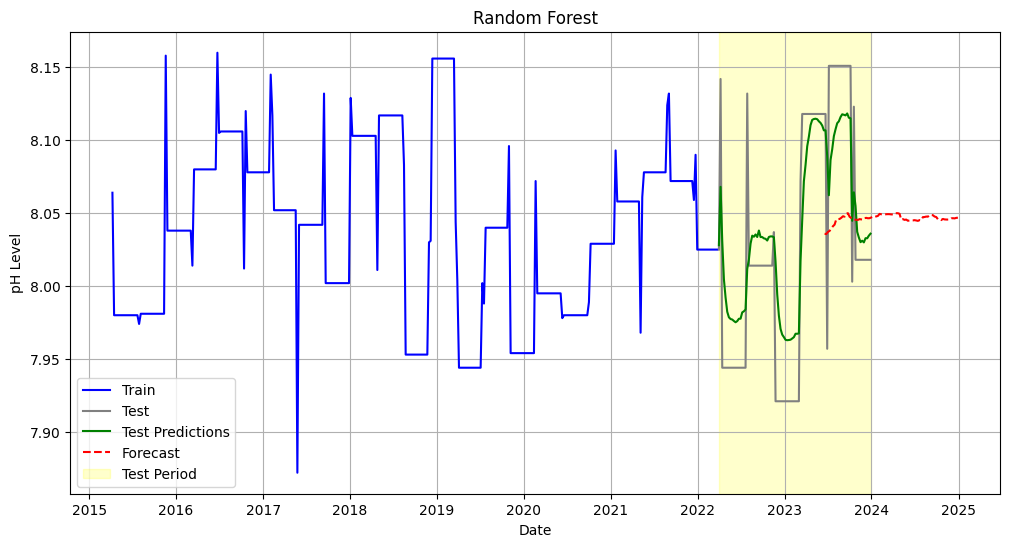

In [12]:
from sklearn.base     import clone
from sklearn.compose  import ColumnTransformer
from sklearn.impute   import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

warnings.filterwarnings("ignore", category=UserWarning, module=r"sklearn\.utils\.parallel")

LAGS             = 12                                                                                      #Number of lagged observations to create
EXOG_LAG_RANGE   = range(1, 3)                                                                             #Exogenous lags 1–2
OVERLAP          = 25                                                                                      #Number of overlapping points for forecast evaluation
RANDOM_STATE     = 42                                                                                      #Random state for reproducibility
ROLL_WINDOWS     = [7, 14]                                                                                 #Rolling mean windows
TARGET           = "pH Level"                                                                              #Target variable name

forecast_start_date = pd.to_datetime("2023-06-15")                                                         #Define forecast start date
df                  = working_copy.copy()                                                                  #Build working copy of dataset

df = df.sort_index()                                                                                       #Sort by index
if not isinstance(df.index, pd.DatetimeIndex):                                                             #Check for DatetimeIndex
    raise ValueError("Expected DatetimeIndex for seasonal features; please ensure index is datetime.")     #  Raise error if not
#                                                                                                          #End index type check

#Rolling means
df[[f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]] = pd.DataFrame({                                      #Create rolling mean features
    f"{TARGET}_rollmean_{w}": df[TARGET].rolling(window=w).mean().shift(1) for w in ROLL_WINDOWS           #  Compute rolling mean with lag
}, index=df.index)                                                                                         #End rolling mean feature creation; index preserved


#Seasonal features
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)                                                  #Create seasonal sine feature
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)                                                  #Create seasonal cosine feature

possible_features = [                                                                                      #List of possible features
                     "Location",                                                                           #  Location
                     "Latitude",                                                                           #  Latitude
                     "Longitude",                                                                          #  Longitude
                     "SST (°C)",                                                                           #  Sea Surface Temperature
                     "Species Observed",                                                                   #  Species Observed
                     "Bleaching Severity Encoded",                                                         #  Bleaching Severity
                     "Marine Heatwave Encoded"                                                             #  Marine Heatwave
]                                                                                                          #End possible features list

features = [f for f in possible_features if f in df.columns]                                               #Select features present in DataFrame

#Lag target features
def create_lags(df, target_col, lags=3):                                                                   #Function to create lagged features
    df_lag = df.copy()                                                                                     #  Create copy of DataFrame
    for lag in range(1, lags + 1):                                                                         #  Iterate over lag range
        df_lag[f"{target_col}_lag{lag}"] = df_lag[target_col].shift(lag)                                   #    Create lagged target feature
    #                                                                                                      #  Next lag value
    df_lag['Date'] = df.index                                                                              #  Preserve dates before dropna
    df_lag = df_lag.dropna().reset_index(drop=True)                                                        #  Align dates with non-NA rows
    return df_lag                                                                                          #  Return lagged DataFrame
#                                                                                                          #End create_lags function

df_lagged      = create_lags(df, TARGET, lags=LAGS)                                                        #Create lagged DataFrame
lag_features   = [f"{TARGET}_lag{lag}" for lag in range(1, LAGS + 1)]                                      #Lag feature names
roll_features  = [f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]                                          #Rolling mean feature names
seasonal_feats = ['month_sin', 'month_cos']                                                                #Seasonal feature names
all_features   = features + lag_features + roll_features + seasonal_feats                                  #All feature names

x              = df_lagged[all_features].copy()                                                            #Feature matrix
y              = df_lagged[TARGET].copy()                                                                  #Target variable
dates          = df_lagged['Date']                                                                         #Dates for reference

#Train/test split
TEST_SIZE               = 0.2                                                                              #Test set size
split_idx               = int(len(x) * (1 - TEST_SIZE))                                                    #Compute split index
x_train, x_test         = x.iloc[:split_idx], x.iloc[split_idx:]                                           #Split features
y_train, y_test         = y.iloc[:split_idx], y.iloc[split_idx:]                                           #Split target variable
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]                                   #Split dates

#Preprocessing
cat_features = [c for c in x.columns if x[c].dtype == 'object' or x[c].dtype.name == 'category']           #Categorical features
num_features = [c for c in x.columns if c not in cat_features]                                             #Numerical features

numeric_transformer = Pipeline([                                                                           #Numeric transformer pipeline
    ('imputer', SimpleImputer(strategy='median')),                                                         #  Impute missing values with median
    ('scaler', StandardScaler())                                                                           #  Standard scaling
])                                                                                                         #End numeric transformer pipeline

categorical_transformer = Pipeline([                                                                       #Categorical transformer pipeline
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),                                 #  Impute missing values with 'MISSING'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))                                #  One-hot encode categorical features
])                                                                                                         #End categorical transformer pipeline

preprocessor = ColumnTransformer([                                                                         #Column transformer for preprocessing
    ('num', numeric_transformer, num_features),                                                            #  Numeric features
    ('cat', categorical_transformer, cat_features)                                                         #  Categorical features
], remainder='drop')                                                                                       #End column transformer

#Random Forest
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)                                           #Initialize Random Forest regressor
pipeline = Pipeline([                                                                                      #Pipeline with preprocessing and model
    ('pre', preprocessor),                                                                                 #  Preprocessing step
    ('model', rf)                                                                                          #  Random Forest model
])                                                                                                         #End pipeline initialization

#TimeSeriesSplit CV
N_SPLITS                                          = 3                                                      #Number of splits for TimeSeriesSplit
tscv                                              = TimeSeriesSplit(n_splits=N_SPLITS)                     #Initialise TimeSeriesSplit
fold_train_rmse, fold_train_mae, fold_train_r2    = [], [], []                                             #Prepare lists to hold training fold metrics
fold_val_rmse_rf, fold_val_mae_rf, fold_val_r2_rf = [], [], []                                             #Prepare lists to hold validation fold metrics

for fold, (train_idx, val_idx) in enumerate(tscv.split(x_train)):                                          #Iterate over folds
    x_tr, x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]                                           #  Split features for training and validation portions
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]                                           #  Split target variable for training and validation portions

    fold_model = clone(pipeline)                                                                           #  Clone pipeline for current fold
    fold_model.fit(x_tr, y_tr)                                                                             #  Fit pipeline on training portion of fold

    y_tr_pred = fold_model.predict(x_tr)                                                                   #  Predict on training portion of fold
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))                                   #  Compute and store RMSE
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))                                            #  Compute and store MAE
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))                                                        #  Compute and store R²

    y_val_pred = fold_model.predict(x_val)                                                                 #  Predict on validation portion of fold
    fold_val_rmse_rf.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))                                #  Compute and store RMSE
    fold_val_mae_rf.append(mean_absolute_error(y_val, y_val_pred))                                         #  Compute and store MAE
    fold_val_r2_rf.append(r2_score(y_val, y_val_pred))                                                     #  Compute and store R²

    print(                                                                                                 #  Print fold metrics
        f"Fold {fold+1}: "                                                                                 #    Fold number
        f"RMSE={fold_val_rmse_rf[-1]:.4f}, "                                                               #    RMSE
        f"MAE={fold_val_mae_rf[-1]:.4f}, "                                                                 #    MAE
        f"R²={fold_val_r2_rf[-1]:.4f}"                                                                     #    R²
    )                                                                                                      #  End print
#                                                                                                          #Next fold iteration

print("\n--- TRAIN METRICS ---")                                                                           #Print average training metrics header
print(f"RMSE: {np.mean(fold_train_rmse):.4f}")                                                             #Print mean RMSE
print(f"MAE : {np.mean(fold_train_mae):.4f}")                                                              #Print mean MAE
print(f"R²  : {np.mean(fold_train_r2):.4f}")                                                               #Print mean R²

print("\n--- VALIDATION METRICS ---")                                                                      #Print average validation metrics header
print(f"RMSE: {np.mean(fold_val_rmse_rf):.4f}")                                                            #Print mean RMSE
print(f"MAE : {np.mean(fold_val_mae_rf):.4f}")                                                             #Print mean MAE
print(f"R²  : {np.mean(fold_val_r2_rf):.4f}")                                                              #Print mean R²

#Grid search
param_grid = {                                                                                             #Hyperparameter grid for Random Forest
    'model__n_estimators'     : [50, 100, 300, 500],                                                       #  Number of trees
    'model__max_depth'        : [None, 10, 20, 30, 50],                                                    #  Maximum tree depth
    'model__max_features'     : ['sqrt', 0.3],                                                             #  Maximum features per split
    'model__min_samples_split': [2, 5, 10, 20]                                                             #  Minimum samples to split a node
}                                                                                                          #End hyperparameter grid

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv, scoring='r2')               #Initialise GridSearchCV
grid_search.fit(x_train, y_train)                                                                          #Fit grid search on full training set

rf_best_model = grid_search.best_estimator_                                                                #Retrieve best model from grid search
print("Best params:", grid_search.best_params_)                                                            #Print best hyperparameters
best_model = rf_best_model                                                                                 #Assign best model for clarity

#Test set evaluation
y_test_pred = best_model.predict(x_test)                                                                   #Predict on test set
final_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))                                             #Compute RMSE on test set
final_mae   = mean_absolute_error(y_test, y_test_pred)                                                     #Compute MAE on test set
final_r2    = r2_score(y_test, y_test_pred)                                                                #Compute R² on test set

print("\n--- TEST METRICS ---")                                                                            #Print test set metrics header
print(f"RMSE: {final_rmse:.4f}")                                                                           #Print RMSE
print(f"MAE: {final_mae:.4f}")                                                                             #Print MAE
print(f"R²: {final_r2:.4f}")                                                                               #Print R²

#Forecast
freq           = 'W'                                                                                       #Frequency for future index
future_index   = pd.date_range(start=forecast_start_date, end=pd.to_datetime("2024-12-31"), freq=freq)     #Create future index for forecasted values
FORECAST_WEEKS = len(future_index)                                                                         #Number of weeks to forecast

if OVERLAP > 0:                                                                                            #If overlap is specified
    x_forecast_input = pd.concat([x_test.iloc[:OVERLAP], x_test.iloc[-(FORECAST_WEEKS - OVERLAP):]])       #  Use overlapping test portion plus additional future rows
else:                                                                                                      #otherwise
    x_forecast_input = x_test.iloc[-FORECAST_WEEKS:]                                                       #  Use last rows equal to forecast length
#                                                                                                          #End overlap check

last_known   = x_forecast_input.tail(LAGS).copy().reset_index(drop=True)                                   #Last known data for recursive forecasting
pH_history   = list(y_train) + list(y_test)                                                                #Full historical target
future_preds = []                                                                                          #Container for future predictions

for i in range(FORECAST_WEEKS):                                                                            #Iterate over forecast steps
    last_row = last_known.tail(1).iloc[0].copy()                                                           #  Get last known row

    #Update target lags and rollmeans from history
    for lag in range(1, LAGS + 1):                                                                         #  Iterate over lag features
        last_row[f"{TARGET}_lag{lag}"] = pH_history[-lag]                                                  #    Update lagged pH feature
    #                                                                                                      #  Next lag feature
    for w in ROLL_WINDOWS:                                                                                 #  Iterate over rolling window sizes
        last_row[f"{TARGET}_rollmean_{w}"] = np.mean(pH_history[-w:])                                      #    Update rolling mean feature
    #                                                                                                      #  Next rolling window feature

    #Seasonal for the forecast step
    step_date = future_index[i]                                                                            #  Current forecast date
    last_row['month_sin'] = np.sin(2 * np.pi * step_date.month / 12)                                       #  Update seasonal sine feature
    last_row['month_cos'] = np.cos(2 * np.pi * step_date.month / 12)                                       #  Update seasonal cosine feature

    x_next_df = pd.DataFrame([last_row], columns=all_features)                                             #  Create DataFrame for next-step prediction
    y_next    = best_model.predict(x_next_df)[0]                                                           #  Predict next pH level

    future_preds.append(y_next)                                                                            #  Append prediction to future predictions
    pH_history.append(y_next)                                                                              #  Append prediction to history

    last_known = pd.concat([last_known, last_row.to_frame().T], ignore_index=True)                         #  Update last known with new row
#                                                                                                          #Next forecast step iteration

y_forecast_series = pd.Series(future_preds, index=future_index)                                            #Create forecasted pH series with future index

if OVERLAP > 0:                                                                                            #If overlap is specified
    y_overlap          = y_test.iloc[:OVERLAP]                                                             #  Actual pH levels for overlapping portion
    y_forecast_overlap = y_forecast_series.iloc[:OVERLAP]                                                  #  Forecasted pH levels for overlapping portion
    rmse_forecast      = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))                        #  RMSE for overlapping portion
    mae_forecast       = mean_absolute_error(y_overlap, y_forecast_overlap)                                #  MAE for overlapping portion

    print(f"\n--- FORECAST METRICS ---")                                                                   #  Print forecast evaluation header
    print(f"RMSE: {rmse_forecast:.4f}")                                                                    #  Print RMSE
    print(f"MAE: {mae_forecast:.4f}")                                                                      #  Print MAE
#                                                                                                          #End overlap check

#Plot
plt.figure(figsize=(12, 6))                                                                                #Create figure
plt.plot(dates_train, y_train, label='Train', color='blue')                                                #Plot training data
plt.plot(dates_test, y_test, label='Test', color='gray')                                                   #Plot test data
plt.plot(dates_test, y_test_pred, label='Test Predictions', color='green')                                 #Plot test predictions
plt.plot(future_index, y_forecast_series, label='Forecast', color='red', linestyle='--')                   #Plot forecasted values
plt.axvspan(dates_test.iloc[0], dates_test.iloc[-1], color='yellow', alpha=0.2, label='Test Period')       #Highlight test period
plt.xlabel('Date')                                                                                         #Set x-axis label
plt.ylabel('pH Level')                                                                                     #Set y-axis label
plt.title('Random Forest')                                                                                 #Set plot title
plt.legend()                                                                                               #Show legend
plt.grid(True)                                                                                             #Enable grid
plt.savefig('Random_Forest.png')
plt.show()                                                                                                 #Display plot

#Allow best_model, x_test, x_train, y_test, y_train and RANDOM_STATE to be used in the next code block
#Allow grid_search to be used in cell 32

del df, df_lagged, x_forecast_input, last_known, lag_features, roll_features, seasonal_feats, all_features #exog_lag_feats
del dates_train, dates_test, fold_model, y_tr, y_val, x_tr, x_val
del y_tr_pred, y_val_pred, fold_train_rmse, fold_train_mae, fold_train_r2
del fold_val_rmse_rf, fold_val_mae_rf, fold_val_r2_rf, pipeline, rf, param_grid, tscv, split_idx


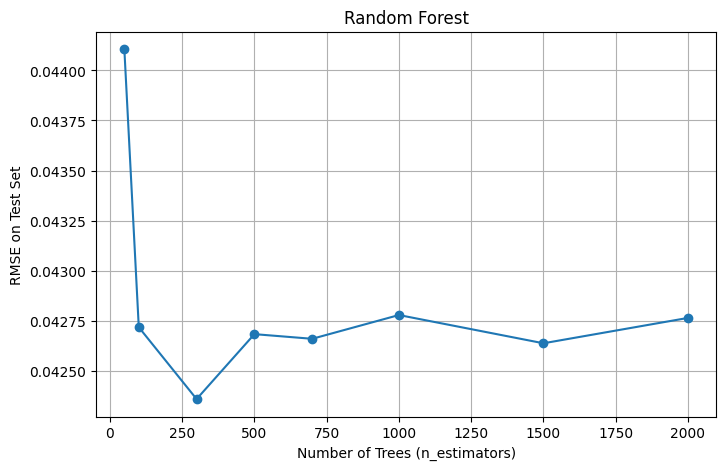

In [13]:
from sklearn.metrics import root_mean_squared_error

n_tree_list = [50, 100, 300, 500, 700, 1000, 1500, 2000]                                                    #List of n_estimators to evaluate
rmse_scores = []                                                                                            #List to hold RMSE scores

#Use best search params if available; otherwise fall back to defaults
base_max_depth         = None                                                                               #Default max_depth
base_min_samples_split = 2                                                                                  #Default min_samples_split
base_max_features      = 'sqrt'                                                                             #Default max_features

if 'grid_search' in globals():                                                                              #Prefer parameters from grid search results
    best_params            = getattr(grid_search, 'best_params_', {})                                       #  Safely grab best params if present
    base_max_depth         = best_params.get('model__max_depth', base_max_depth)                            #  Use tuned max_depth when available
    base_min_samples_split = best_params.get('model__min_samples_split', base_min_samples_split)            #  Use tuned min_samples_split when available
    base_max_features      = best_params.get('model__max_features', base_max_features)                      #  Use tuned max_features when available
elif 'best_model' in globals():                                                                             #Fallback to previous best_model if still defined
    model_step = best_model.named_steps.get('model') if hasattr(best_model, 'named_steps') else best_model  #  Extract RF model
    base_max_depth         = getattr(model_step, 'max_depth', base_max_depth)                               #  Use model max_depth if present
    base_min_samples_split = getattr(model_step, 'min_samples_split', base_min_samples_split)               #  Use model min_samples_split if present
    base_max_features      = getattr(model_step, 'max_features', base_max_features)                         #  Use model max_features if present

for n_trees in n_tree_list:                                                                                 #Iterate over number of trees
    rf_temp = RandomForestRegressor(                                                                        #Initialise temporary Random Forest model
        n_estimators      = n_trees,                                                                        #  Number of trees
        max_depth         = base_max_depth,                                                                 #  Tuned/derived maximum depth
        min_samples_split = base_min_samples_split,                                                         #  Tuned/derived minimum samples split
        max_features      = base_max_features,                                                              #  Tuned/derived max features
        random_state      = RANDOM_STATE,                                                                   #  Random state for reproducibility
        n_jobs=-1                                                                                           #  Use all available CPU cores
    )                                                                                                       #End temporary Random Forest model

    pipeline_temp = Pipeline([                                                                              #Pipeline combining preprocessing and temporary model
        ('pre', preprocessor),                                                                              #  Preprocessing step
        ('model', rf_temp)                                                                                  #  Temporary Random Forest model
        ])                                                                                                  #End pipeline combining preprocessing and model
    pipeline_temp.fit(x_train, y_train)                                                                     #Fit pipeline on training data
    y_val_pred = pipeline_temp.predict(x_test)                                                              #Predict on test set     
    rmse_scores.append(root_mean_squared_error(y_test, y_val_pred))                                         #Compute and store RMSE score

plt.figure(figsize=(8,5))                                                                                   #Create figure
plt.plot(n_tree_list, rmse_scores, marker='o')                                                              #Plot RMSE scores vs. number of trees
plt.xlabel("Number of Trees (n_estimators)")                                                                #Set x-axis label
plt.ylabel("RMSE on Test Set")                                                                              #Set y-axis label
plt.title("Random Forest")                                                                                  #Set plot title
plt.grid(True)                                                                                              #Enable grid
plt.savefig("Hyperparameter_Tuning_RF.png")                                                                 #Save figure
plt.show()                                                                                                  #Display the chart

del n_tree_list, rmse_scores, n_trees, rf_temp, pipeline_temp, y_val_pred                                   #Clean up temporary variables to prevent scope bleed
del x_test, x_train, y_train, y_test                                                                        #Clean up variables to prevent scope bleed; these are redefined in the next code block
del base_max_depth, base_min_samples_split, base_max_features                                               #Remove derived parameter holders
del best_params                                                                                             #Remove best_params dictionary if created

## XGBoost

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 300, 'model__subsample': 0.6}
Fold 1: RMSE=0.0507, MAE=0.0416, R²=0.1034
Fold 2: RMSE=0.0594, MAE=0.0524, R²=0.3096
Fold 3: RMSE=0.0241, MAE=0.0186, R²=0.5580

--- TRAIN METRICS ---
RMSE: 0.0257
MAE : 0.0164
R²  : 0.7997

--- VALIDATION METRICS ---
RMSE: 0.0447
MAE : 0.0376
R²  : 0.3237

--- TEST METRICS ---
RMSE: 0.0458
MAE : 0.0385
R²  : 0.7060

--- FORECAST METRICS ---
RMSE: 0.0459
MAE: 0.0406


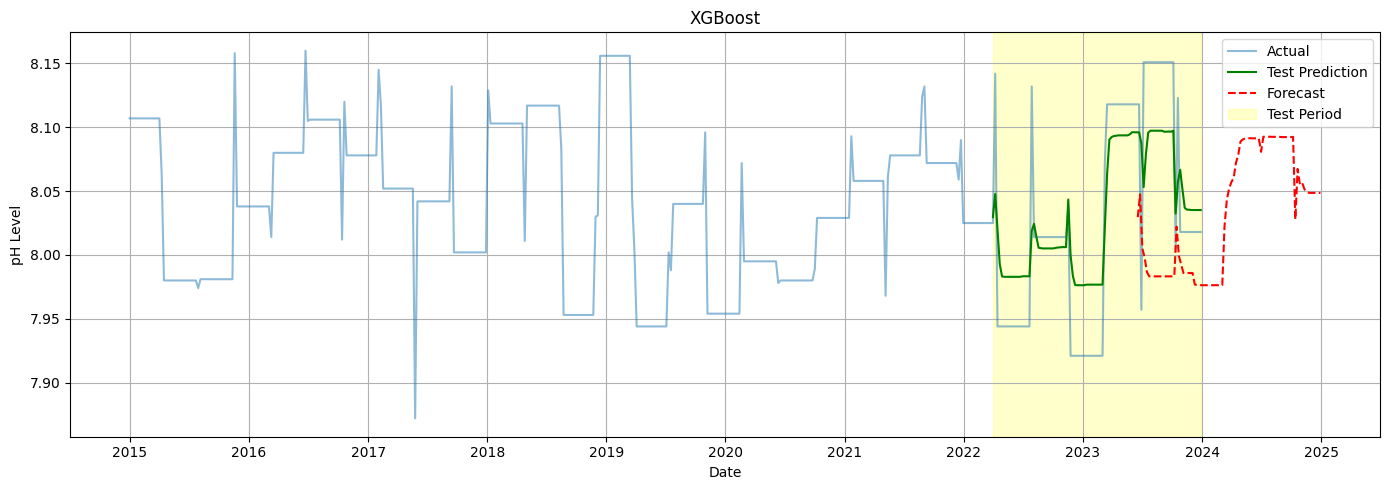

In [14]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import xgboost           as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base            import clone

warnings.filterwarnings("ignore")

FORECAST_END_DATE   = pd.to_datetime("2024-12-31")                                                                #Model forecast end date
FORECAST_START_DATE = pd.to_datetime("2023-06-15")                                                                #Model forecast start date
LAGS                = 12                                                                                          #Number of lagged observations to create
ROLL_WINDOWS        = [7, 14]                                                                                     #Rolling mean windows
N_SPLITS            = 3                                                                                           #Number of splits for TimeSeriesSplit
OVERLAP             = 25                                                                                          #Overlap between splits
RANDOM_STATE        = 42                                                                                          #Random state for reproducibility
TARGET              = "pH Level"                                                                                  #Target variable
TEST_SIZE           = 0.2                                                                                         #Proportion of data to be used as test set
                                                                                
xgboostDF = working_copy.copy(deep=True)                                                                          #Build a local copy of the working dataset

if not isinstance(xgboostDF.index, pd.DatetimeIndex):                                                             #Check if index is a DatetimeIndex
    raise ValueError("Data must have a DatetimeIndex")                                                            #  Raise error if not
#                                                                                                                 #End index type check

xgboostDF     = xgboostDF.sort_index()                                                                            #Sort dataset by index (date)
base_features = [                                                                                                 #Base features list
                 "Latitude",                                                                                      #  Geographic latitude
                 "Longitude",                                                                                     #  Geographic longitude
                 "SST (°C)",                                                                                      #  Sea Surface Temperature in Celsius
                 "Species Observed",                                                                              #  Number of species observed
                 "Bleaching Severity Encoded",                                                                    #  Encoded bleaching severity
                 "Marine Heatwave Encoded"                                                                        #  Encoded marine heatwave occurrence
]                                                                                                                 #End base features list

base_features = [f for f in base_features if f in xgboostDF.columns]                                              #Ensure features exist in dataset

#Rolling mean features
for w in ROLL_WINDOWS:                                                                                            #Iterate over rolling windows
    xgboostDF[f"{TARGET}_rollmean_{w}"] = xgboostDF[TARGET].rolling(window=w).mean().shift(1)                     #  Create rolling mean feature
#                                                                                                                 #Next rolling window iteration
                                                                                                                
#Seasonal features
xgboostDF['month_sin'] = np.sin(2 * np.pi * xgboostDF.index.month / 12)                                           #Seasonality sine
xgboostDF['month_cos'] = np.cos(2 * np.pi * xgboostDF.index.month / 12)                                           #Seasonality cosine

def create_lags(df, target, lags=3):                                                                              #Function to create lagged features
    df_lag = df.copy()                                                                                            #  Create a copy of the dataset
    for lag in range(1, lags + 1):                                                                                #  Iterate over lag numbers
        df_lag[f"{target}_lag{lag}"] = df_lag[target].shift(lag)                                                  #    Create lagged feature by shifting target
#                                                                                                                 #  End lag creation loop
    df_lag['Date'] = df_lag.index                                                                                 #  Preserve date for reference
    return df_lag.dropna().reset_index(drop=True)                                                                 #  Return DataFrame with NaNs dropped
#                                                                                                                 #End create_lags function

df_lagged = create_lags(xgboostDF, TARGET, lags=LAGS)                                                             #Create lagged dataset

lag_features    = [f"{TARGET}_lag{i}" for i in range(1, LAGS + 1)]                                                #Lagged feature names
roll_features   = [f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]                                                #List of rolling mean features
seasonal_feats  = ['month_sin', 'month_cos']                                                                      #Seasonal feature names
FEATURES        = base_features + seasonal_feats + lag_features + roll_features                                   #All features

x     = df_lagged[FEATURES]                                                                                       #Feature matrix
y     = df_lagged[TARGET]                                                                                         #Target vector
dates = df_lagged['Date']                                                                                         #Dates for reference

#Train/test split
split_idx = int(len(x) * (1 - TEST_SIZE))                                                                         #Calculate split index based on TEST_SIZE

x_train, x_test         = x.iloc[:split_idx], x.iloc[split_idx:]                                                  #Feature train/test split
y_train, y_test         = y.iloc[:split_idx], y.iloc[split_idx:]                                                  #Target train/test split
dates_train, dates_test = dates[:split_idx], dates[split_idx:]                                                    #Dates train/test split

#Pipeline
pipeline = Pipeline([                                                                                             #Model pipeline
    ("scaler", StandardScaler()),                                                                                 #  Standard scaler for feature scaling
    ("model", xgb.XGBRegressor(                                                                                   #  XGBoost regressor
        objective        = "reg:squarederror",                                                                    #    Regression objective
        random_state     = RANDOM_STATE,                                                                          #    Random state for reproducibility
        n_estimators     = 300,                                                                                   #    Number of trees
        max_depth        = 3,                                                                                     #    Maximum tree depth
        learning_rate    = 0.05,                                                                                  #    Learning rate
        subsample        = 0.7,                                                                                   #    Subsample ratio
        colsample_bytree = 0.7,                                                                                   #    Column subsample ratio
        reg_alpha        = 1.0,                                                                                   #    L1 regularization
        reg_lambda       = 2.0,                                                                                   #    L2 regularization
        min_child_weight = 5,                                                                                     #    Minimum sum of instance weight needed in a child
        tree_method      = "hist"                                                                                 #    Tree construction algorithm
    ))                                                                                                            #  End XGBoost regressor
])                                                                                                                #End model pipeline

#Time Series CV
tscv = TimeSeriesSplit(n_splits=N_SPLITS)                                                                         #TimeSeriesSplit object

#Grid Search
param_grid = {                                                                                                    #Hyperparameter grid for GridSearchCV
    "model__max_depth"       : [2, 3, 4],                                                                         #  Maximum tree depth
    "model__learning_rate"   : [0.03, 0.05],                                                                      #  Learning rate
    "model__n_estimators"    : [200, 300],                                                                        #  Number of trees
    "model__subsample"       : [0.6, 0.8],                                                                        #  Subsample ratio
    "model__colsample_bytree": [0.6, 0.8]                                                                         #  Column subsample ratio
}                                                                                                                 #End hyperparameter grid

grid = GridSearchCV(                                                                                              #Grid search object
    pipeline,                                                                                                     #  Pipeline to optimise
    param_grid,                                                                                                   #  Hyperparameter grid
    cv      = tscv,                                                                                               #  TimeSeriesSplit cross-validation
    scoring = "neg_mean_absolute_error",                                                                          #  Scoring metric
    n_jobs  = -1,                                                                                                 #  Use all available cores
    verbose = 1                                                                                                   #  Verbosity level
)                                                                                                                 #End GridSearchCV object

grid.fit(x_train, y_train)                                                                                        #Fit grid search on training data
best_model = grid.best_estimator_                                                                                 #Retrieve best model from grid search

print("\nBest parameters:", grid.best_params_)                                                                    #Print best hyperparameters

#Cross-validated fold metrics for tuned model
scoring = {                                                                                                       #Define scoring dictionary for cross_validate
    "rmse": "neg_root_mean_squared_error",                                                                        #  RMSE metric
    "mae" : "neg_mean_absolute_error",                                                                            #  MAE metric
    "r2"  : "r2"                                                                                                  #  R² metric
}                                                                                                                 #End scoring dictionary

cv_results = cross_validate(                                                                                      #Run cross-validation on tuned model
    best_model,                                                                                                   #  Tuned model
    x_train,                                                                                                      #  Training features
    y_train,                                                                                                      #  Training target
    cv=tscv,                                                                                                      #  TimeSeriesSplit cross-validation
    scoring            = scoring,                                                                                 #  Scoring metrics
    return_train_score = True,                                                                                    #  Return training scores
    n_jobs             = -1                                                                                       #  Use all available cores
)                                                                                                                 #End cross_validate call

xgb_val_rmse   = -cv_results["test_rmse"]                                                                         #Validation RMSE per fold
xgb_val_mae    = -cv_results["test_mae"]                                                                          #Validation MAE per fold
xgb_val_r2     = cv_results["test_r2"]                                                                            #Validation R² per fold

for i in range(N_SPLITS):                                                                                         #Iterate over folds
    print(                                                                                                        #  Print fold results
        f"Fold {i+1}: "                                                                                           #    Fold number
        f"RMSE={xgb_val_rmse[i]:.4f}, "                                                                           #    RMSE
        f"MAE={xgb_val_mae[i]:.4f}, "                                                                             #    MAE
        f"R²={xgb_val_r2[i]:.4f}"                                                                                 #    R²
    )                                                                                                             #  End print
#                                                                                                                 #Next fold iteration

#Refit tuned model on full training data for final reporting
best_model.fit(x_train, y_train)                                                                                  #Ensure estimator uses full training span

y_train_pred    = best_model.predict(x_train)                                                                     #Training predictions from tuned model
train_rmse_full = np.sqrt(mean_squared_error(y_train, y_train_pred))                                              #Training RMSE on full training data
train_mae_full  = mean_absolute_error(y_train, y_train_pred)                                                      #Training MAE on full training data
train_r2_full   = r2_score(y_train, y_train_pred)                                                                 #Training R² on full training data

y_test_pred = best_model.predict(x_test)                                                                          #Predict on test set

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))                                                      #Test RMSE
test_mae  = mean_absolute_error(y_test, y_test_pred)                                                              #Test MAE
test_r2   = r2_score(y_test, y_test_pred)                                                                         #Test R²

print("\n--- TRAIN METRICS ---")                                                                                  #Print fit-on-all training metrics
print(f"RMSE: {train_rmse_full:.4f}")                                                                             #Print training RMSE
print(f"MAE : {train_mae_full:.4f}")                                                                              #Print training MAE
print(f"R²  : {train_r2_full:.4f}")                                                                               #Print training R²

print("\n--- VALIDATION METRICS ---")                                                                             #Print cross-validated validation metrics
print(f"RMSE: {xgb_val_rmse.mean():.4f}")                                                                         #Print mean validation RMSE
print(f"MAE : {xgb_val_mae.mean():.4f}")                                                                          #Print mean validation MAE
print(f"R²  : {xgb_val_r2.mean():.4f}")                                                                           #Print mean validation R²

print("\n--- TEST METRICS ---")                                                                                   #Print test set metrics header
print(f"RMSE: {test_rmse:.4f}")                                                                                   #Print test set RMSE
print(f"MAE : {test_mae:.4f}")                                                                                    #Print test set MAE
print(f"R²  : {test_r2:.4f}")                                                                                     #Print test set R²

#Prepare forecast input
future_index = pd.date_range(                                                                                     #Create future date index
    start = FORECAST_START_DATE,                                                                                  #  Forecast start date
    end   = FORECAST_END_DATE,                                                                                    #  Forecast end date
    freq  = "W"                                                                                                   #  Weekly frequency
)                                                                                                                 #End future date index creation

if OVERLAP > 0:                                                                                                   #If overlap is specified
    x_forecast_input = pd.concat([x_test.iloc[:OVERLAP], x_test.iloc[-(len(future_index) - OVERLAP):]])           #  Use overlap plus tail rows
else:                                                                                                             #otherwise
    x_forecast_input = x_test.iloc[-len(future_index):]                                                           #  Use last rows
#                                                                                                                 #End overlap check

pH_history   = list(y_train) + list(y_test)                                                                       #Full historical target
future_preds = []                                                                                                 #List to hold future predictions

for i in range(len(future_index)):                                                                               #Iterate over future steps
    last_row = x_forecast_input.iloc[min(i, len(x_forecast_input)-1)].copy()                                     #  Base row (progress through overlap then hold last)

    #Update target lags and rollmeans from history
    for lag in range(1, LAGS + 1):                                                                               #  Iterate over lag features
        last_row[f"{TARGET}_lag{lag}"] = pH_history[-lag]                                                        #    Update lagged pH feature
    #                                                                                                            #  Next lag feature iteration
    for w in ROLL_WINDOWS:                                                                                       #  Iterate over rolling windows
        last_row[f"{TARGET}_rollmean_{w}"] = np.mean(pH_history[-w:])                                            #    Update rolling mean
    #                                                                                                            #  Next rolling window

    #Seasonal features for forecast step
    step_date = future_index[i]                                                                                  #  Current forecast date
    last_row['month_sin'] = np.sin(2 * np.pi * step_date.month / 12)                                             #  Update seasonal sine
    last_row['month_cos'] = np.cos(2 * np.pi * step_date.month / 12)                                             #  Update seasonal cosine

    x_next_df = pd.DataFrame([last_row], columns=FEATURES)                                                       #  Build next-step feature frame
    pred      = best_model.predict(x_next_df)[0]                                                                 #  Predict next pH level

    future_preds.append(pred)                                                                                    #  Append prediction
    pH_history.append(pred)                                                                                      #  Update history

y_forecast = pd.Series(future_preds, index=future_index)                                                         #Create a Series for future predictions

#Forecast metrics on overlapping portion
if OVERLAP > 0:                                                                                                  #Check if overlap evaluation is needed
    y_overlap = y_test.iloc[:OVERLAP]                                                                            #  Get actual values for overlap period
    y_hat     = y_forecast.iloc[:OVERLAP]                                                                        #  Get forecasted values for overlap period

    rmse_forecast = np.sqrt(mean_squared_error(y_overlap, y_hat))                                                #  Calculate RMSE for overlap period
    mae_forecast  = mean_absolute_error(y_overlap, y_hat)                                                        #  Calculate MAE for overlap period

    print("\n--- FORECAST METRICS ---")                                                                          #  Print forecast metrics header
    print(f"RMSE: {rmse_forecast:.4f}")                                                                          #  Print RMSE for overlap period
    print(f"MAE: {mae_forecast:.4f}")                                                                            #  Print MAE for overlap period
#                                                                                                                #End overlap check

#Plot
plt.figure(figsize=(14, 5))                                                                                      #Create figure
plt.plot(xgboostDF.index, xgboostDF[TARGET], label="Actual", alpha=0.5)                                          #Plot actual values
plt.plot(dates_test, y_test_pred, label="Test Prediction", color="green")                                        #Plot test predictions
plt.plot(y_forecast.index, y_forecast, "--", color="red", label="Forecast")                                      #Plot forecasted values
plt.axvspan(dates_test.iloc[0], dates_test.iloc[-1], color="yellow", alpha=0.2, label="Test Period")             #Highlight test period

plt.title("XGBoost")                                                                                             #Plot title
plt.xlabel("Date")                                                                                               #X-axis label
plt.ylabel("pH Level")                                                                                           #Y-axis label
plt.legend()                                                                                                     #Show legend
plt.grid(True)                                                                                                   #Enable grid
plt.tight_layout()                                                                                               #Tight layout
plt.savefig("XGBoost.png")                                                                                       #Save figure
plt.show()                                                                                    

del xgboostDF, base_features, lag_features, roll_features, FEATURES,  seasonal_feats, #exog_lag_feats,             #Clean up large structures
del split_idx, x_train, x_test, y_train, y_test, dates_train, dates_test, x, y, dates, pH_history, future_preds    #Clean up splits and temps

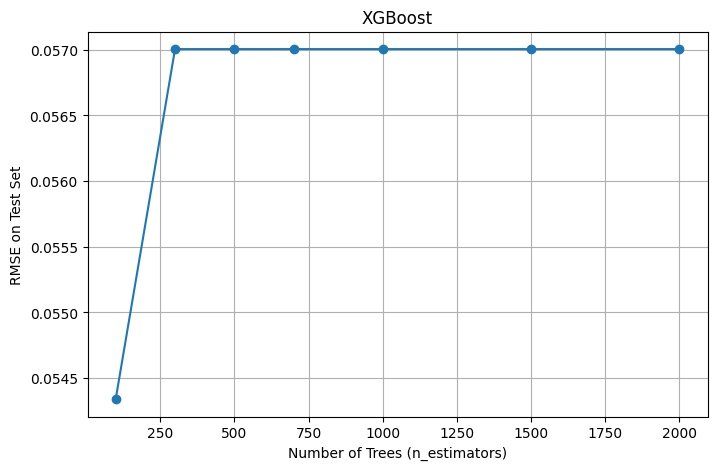

In [15]:
data = working_copy[['pH Level',                                                                                              #Create DataFrame with relevant columns
                     'SST (°C)',                                                                                              #  Sea Surface Temperature
                     'Marine Heatwave Encoded',                                                                               #  Marine Heatwave Encoded
                     'Bleaching Severity Encoded',                                                                            #  Bleaching Severity Encoded
                     'Species Observed',                                                                                      #  Species Observed
                     'Latitude',                                                                                              #  Latitude
                     'Longitude']].rename(columns={'pH Level': 'pH'})                                                         #  Longitude and rename target
#                                                                                                                             #End DataFrame creation
y = data['pH']                                                                                                                #y-axis target variable
x = data.drop('pH', axis=1)                                                                                                   #x-axis features

split_idx       = int(len(x) * 0.8)                                                                                           #Split the data into 80% train and 20% test
x_train, x_test = x.iloc[:split_idx], x.iloc[split_idx:]                                                                      #Assign x-axis train and test features
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]                                                                      #Assign y-axis train and test features

#Scale
scaler         = StandardScaler()                                                                                             #Initialise StandardScaler
x_train_scaled = scaler.fit_transform(x_train)                                                                                #Fit and transform training features
x_test_scaled  = scaler.transform(x_test)                                                                                     #Transform testing features

y_train_1d = np.ravel(y_train)                                                                                                #Flatten y_train to 1D array
y_test_1d  = np.ravel(y_test)                                                                                                 #Flatten y_test to 1D array

assert x_train_scaled.shape[0] == y_train_1d.shape[0], f"X_train: {x_train_scaled.shape[0]}, y_train: {y_train_1d.shape[0]}"  #Ensure training features and targets have matching number of samples
assert x_test_scaled.shape[0]  == y_test_1d.shape[0], f"X_test: {x_test_scaled.shape[0]}, y_test: {y_test_1d.shape[0]}"       #Ensure testing features and targets have matching number of samples

#XGBoost
n_estimators_list = [100, 300, 500, 700, 1000, 1500, 2000]                                                                    #List of n_estimators to evaluate
rmse_scores = []                                                                                                              #List to hold RMSE scores

#GridSearchCV
best_params  = grid_search.best_params_                                                                                       #Get best parameters from previous grid search (grid_search comes from Random Forest)
fixed_params = {                                                                                                              #Fixed parameters for evaluation
                'max_depth'       : best_params.get('max_depth', 3),                                                          #  Maximum depth
                'learning_rate'   : best_params.get('learning_rate', 0.1),                                                    #  Learning rate
                'subsample'       : best_params.get('subsample', 1.0),                                                        #  Subsample ratio
                'colsample_bytree': best_params.get('colsample_bytree', 1.0),                                                 #  Column sample by tree
                'random_state'    : 42                                                                                        #  Random state for reproducibility
}                                                                                                                             #End fixed parameters

for n in n_estimators_list:                                                                                                   #Iterate over number of trees
    model_temp = xgb.XGBRegressor(n_estimators=n, **fixed_params)                                                             #  Initialise temporary XGBoost model
    model_temp.fit(x_train_scaled, y_train_1d)                                                                                #  Fit temporary model on training data
    y_pred     = model_temp.predict(x_test_scaled)                                                                            #  Predict on test set
    rmse_scores.append(root_mean_squared_error(y_test_1d, y_pred))                                                            #  Compute and store RMSE score
#                                                                                                                             #Next n_estimators iteration

#Plot
plt.figure(figsize=(8,5))                                                                                                     #Create figure
plt.plot(n_estimators_list, rmse_scores, marker='o', linestyle='-')                                                           #Plot RMSE scores vs. number of trees
plt.xlabel("Number of Trees (n_estimators)")                                                                                  #Set x-axis label
plt.ylabel("RMSE on Test Set")                                                                                                #Set y-axis label
plt.title("XGBoost")                                                                                                          #Set plot title
plt.grid(True)                                                                                                                #Enable grid
plt.savefig('Hyperparameter_Tuning_XGBoost.png')
plt.show()                                                                                                                    #Display plot

del x, y, split_idx, scaler, x_train_scaled, x_test_scaled, n_estimators_list, rmse_scores                                    #Clean up temporary variables to prevent scope bleed
del x_test, x_train, y_train, y_test                                                                                          #Clean up variables to prevent scope bleed; these are redefined in the next code block

## Hybrid

Fold 1: RMSE=0.0553, MAE=0.0406, R²=0.1664
Fold 2: RMSE=0.0576, MAE=0.0550, R²=0.3408
Fold 3: RMSE=0.0238, MAE=0.0173, R²=0.5832

--- TRAIN METRICS ---
RMSE: 0.0088
MAE : 0.0031
R²  : 0.9729

--- VALIDATION METRICS ---
RMSE: 0.0456
MAE : 0.0376
R²  : 0.3634
Fitting 3 folds for each of 140 candidates, totalling 420 fits

Best params: {'model__max_depth': 14, 'model__min_samples_split': 22, 'model__n_estimators': 200}

--- TEST METRICS ---
RMSE: 0.0296
MAE: 0.0219
R²: 0.8774

---FORECAST METRICS ---
Forecast RMSE: 0.0274
Forecast MAE : 0.0223


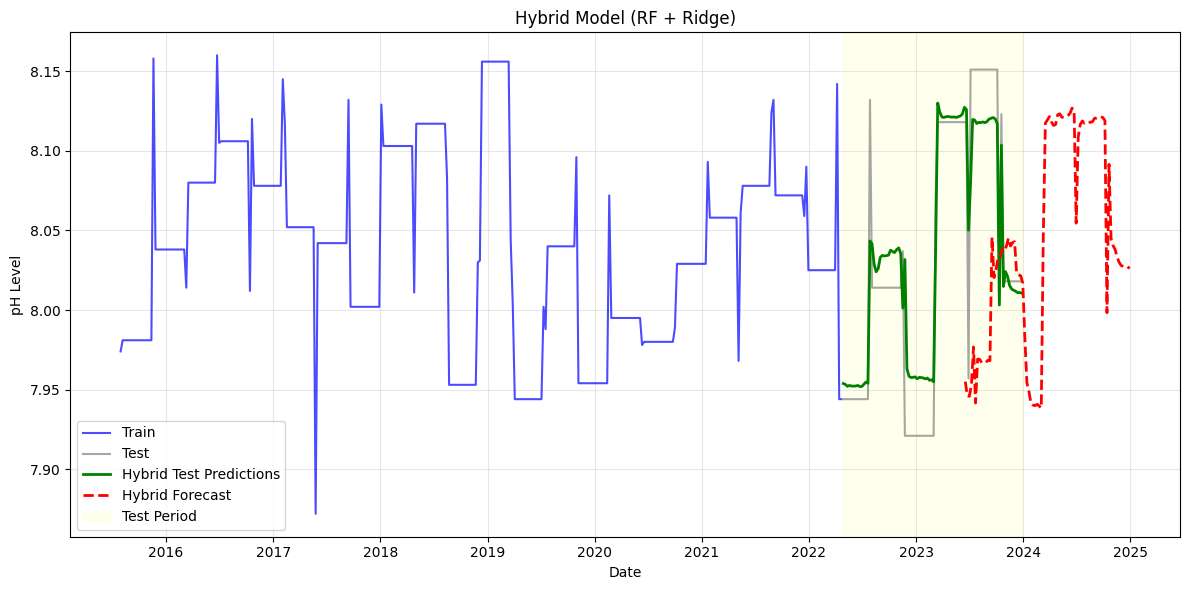

In [16]:
warnings.filterwarnings("ignore", category=UserWarning, module=r"sklearn\.utils\.parallel")

#Parameters
LAGS            = 30                                                                                          #Number of lagged observations to create
OVERLAP         = 25                                                                                          #Number of overlapping points for forecast evaluation
RANDOM_STATE    = 42                                                                                          #Random state for reproducibility
ROLL_WINDOWS    = [7, 14]                                                                                     #Rolling mean windows
TARGET          = "pH Level"                                                                                  #Target column

forecast_start_date = pd.to_datetime("2023-06-15")                                                            #Forecast start date

df    = working_copy.copy(deep=True)                                                                          #Create working copy of dataframe  
dates = df.index                                                                                              #Extract dates from index

#Selecting features
possible_features = [                                                                                         #List of possible features
                     "Location",                                                                              #  Location
                     "Latitude",                                                                              #  Latitude
                     "Longitude",                                                                             #  Longitude
                     "SST (°C)",                                                                              #  Sea Surface Temperature
                     "Species Observed",                                                                      #  Species Observed
                     "Bleaching Severity Encoded",                                                            #  Bleaching Severity Encoded
                     "Marine Heatwave Encoded"                                                                #  Marine Heatwave Encoded
]                                                                                                             #End possible features list
features = [f for f in possible_features if f in df.columns]                                                  #Select features present in dataframe

#Rolling mean features
for w in ROLL_WINDOWS:                                                                                        #Iterate over rolling windows
    df[f"{TARGET}_rollmean_{w}"] = df[TARGET].rolling(window=w).mean().shift(1)                               #  Create rolling mean feature
#                                                                                                             #Next rolling window iteration

#Seasonal features
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)                                                     #Seasonal sine
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)                                                     #Seasonal cosine

#Lag features
def create_lags(df, target_col, lags):                                                                        #Function to create lagged features   
    df_lag = df.copy()                                                                                        #  Create copy of dataframe
    for lag in range(1, lags + 1):                                                                            #  Iterate over lag values
        df_lag[f"{target_col}_lag{lag}"] = df_lag[target_col].shift(lag)                                      #    Create lagged feature
    df_lag['Date'] = df_lag.index                                                                             #  Preserve original datetime index
    df_lag = df_lag.dropna()                                                                                  #  Drop NA rows introduced by lag/roll
    df_lag['Date'] = pd.to_datetime(df_lag['Date'])                                                           #  Ensure datetime
    df_lag = df_lag.set_index('Date')                                                                         #  Set Date as index to keep temporal axis
    return df_lag                                                                                             #  Return lagged dataframe
#                                                                                                             #End create_lags function

df_lagged = create_lags(df, TARGET, LAGS)                                                                     #Create lagged dataframe

lag_features      = [f"{TARGET}_lag{lag}" for lag in range(1, LAGS + 1)]                                      #List of lagged features
roll_features     = [f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]                                          #List of rolling mean features
seasonal_features = ['month_sin', 'month_cos']                                                                #Seasonal feature names
all_features      = features + seasonal_features + lag_features + roll_features # + exog_lag_features         #Combine all features into a single list

x     = df_lagged[all_features].copy()                                                                        #Feature matrix
y     = df_lagged[TARGET].copy()                                                                              #Target variable
dates = df_lagged.index                                                                                       #Dates for each observation

#Train/test split
TEST_SIZE               = 0.2                                                                                 #Proportion of data for test set
split_idx               = int(len(x) * (1 - TEST_SIZE))                                                       #Calculate split index
x_train, x_test         = x.iloc[:split_idx], x.iloc[split_idx:]                                              #Split features
y_train, y_test         = y.iloc[:split_idx], y.iloc[split_idx:]                                              #Split target variable
dates_train, dates_test = dates[:split_idx], dates[split_idx:]                                                #Split dates

cat_features = [c for c in x.columns if x[c].dtype == 'object' or x[c].dtype.name == 'category']              #Identify categorical features
num_features = [c for c in x.columns if c not in cat_features]                                                #Identify numerical features

numeric_transformer = Pipeline([                                                                              #Pipeline for numerical features
    ('imputer', SimpleImputer(strategy='median')),                                                            #  Impute missing values with median
    ('scaler', StandardScaler())                                                                              #  Standard scaling
])                                                                                                            #End numeric transformer pipeline

categorical_transformer = Pipeline([                                                                          #Pipeline for categorical features
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),                                    #  Impute missing values with 'MISSING'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))                                   #  One-hot encoding
])                                                                                                            #End categorical transformer pipeline

preprocessor = ColumnTransformer([                                                                            #Column transformer to apply different preprocessing
    ('num', numeric_transformer, num_features),                                                               #  Numerical features
    ('cat', categorical_transformer, cat_features)                                                            #  Categorical features
])                                                                                                            #End column transformer

#Random Forest
rf       = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)                                        #Initialise Random Forest regressor
pipeline = Pipeline([                                                                                         #Create pipeline with preprocessing and model (template for GridSearchCV)
    ('pre', preprocessor),                                                                                    #  Preprocessing step
    ('model', rf)                                                                                             #  Random Forest model
])                                                                                                            #End pipeline

#TimeSeriesSplit CV
N_SPLITS = 3                                                                                                  #Number of splits for TimeSeriesSplit
tscv     = TimeSeriesSplit(n_splits=N_SPLITS)                                                                 #Initialise TimeSeriesSplit

fold_train_rmse, fold_train_mae, fold_train_r2 = [], [], []                                                   #Lists to hold training metrics
fold_val_rmse, fold_val_mae, fold_val_r2       = [], [], []                                                   #Lists to hold validation metrics

for fold, (train_idx, val_idx) in enumerate(tscv.split(x_train)):                                             #Iterate over TimeSeriesSplit folds
    x_tr, x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]                                              #  Split training and validation features
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]                                              #  Split training and validation target variable

    fold_model = clone(pipeline)                                                                              #  Clone the pipeline for the current fold
    fold_model.fit(x_tr, y_tr)                                                                                #  Fit the model on training portion of fold

    y_tr_pred = fold_model.predict(x_tr)                                                                      #  Predict on training portion
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))                                      #  Compute and store RMSE
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))                                               #  Compute and store MAE
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))                                                           #  Compute and store R²

    y_val_pred = fold_model.predict(x_val)                                                                    #  Predict on validation portion
    fold_val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))                                      #  Compute and store RMSE
    fold_val_mae.append(mean_absolute_error(y_val, y_val_pred))                                               #  Compute and store MAE
    fold_val_r2.append(r2_score(y_val, y_val_pred))                                                           #  Compute and store R² 
    
    print(                                                                                                    #  Print fold results
    f"Fold {fold+1}: "                                                                                        #    Fold number
    f"RMSE={fold_val_rmse[-1]:.4f}, "                                                                         #    RMSE
    f"MAE={fold_val_mae[-1]:.4f}, "                                                                           #    MAE
    f"R²={fold_val_r2[-1]:.4f}"                                                                               #    R²
)                                                                                                             #  End print
#                                                                                                             #Next fold iteration

print("\n--- TRAIN METRICS ---")                                                                              #Header for average training metrics
print(f"RMSE: {np.mean(fold_train_rmse):.4f}")                                                                #Print mean RMSE
print(f"MAE : {np.mean(fold_train_mae):.4f}")                                                                 #Print mean MAE
print(f"R²  : {np.mean(fold_train_r2):.4f}")                                                                  #Print mean R²

print("\n--- VALIDATION METRICS ---")                                                                         #Header for average validation metrics
print(f"RMSE: {np.mean(fold_val_rmse):.4f}")                                                                  #Print mean RMSE
print(f"MAE : {np.mean(fold_val_mae):.4f}")                                                                   #Print mean MAE
print(f"R²  : {np.mean(fold_val_r2):.4f}")                                                                    #Print mean R²

#Grid search
param_grid = {                                                                                                #Parameter grid for GridSearchCV
    'model__n_estimators': [100, 200, 300, 400],                                                         #  Number of trees
    'model__max_depth': [8, 10, 11, 12, 13, 14, 16],                                                                    #  Maximum depth of trees
    'model__min_samples_split': [16, 17, 18, 20, 22]                                                                #  Minimum samples required to split a node  
}                                                                                                             #End parameter grid

grid_search = GridSearchCV(                                                                                   #Initialise GridSearchCV
    estimator  = pipeline,                                                                                    #  Pipeline as estimator
    param_grid = param_grid,                                                                                  #  Parameter grid
    cv         = tscv,                                                                                        #  TimeSeriesSplit cross-validation
    scoring    = 'neg_root_mean_squared_error',                                                               #  R² as scoring metric
    n_jobs     = -1,                                                                                          #  Use all available CPU cores
    verbose    = 1                                                                                            #  Verbosity level
)                                                                                                             #End GridSearchCV

grid_search.fit(x_train, y_train)                                                                             #Fit GridSearchCV on training data
best_model = grid_search.best_estimator_                                                                      #Get best model from grid search
print("\nBest params:", grid_search.best_params_)                                                             #Print best parameters

#Train ridge on RF residuals                                                                                  #Header for ridge regression training
rf_train_pred   = best_model.predict(x_train)                                                                 #Predict on training set
residuals_train = y_train - rf_train_pred                                                                     #Calculate residuals
x_train_pre     = best_model.named_steps['pre'].transform(x_train)                                            #Preprocess training features

ridge_model = Ridge(alpha = 1)                                                                                #Ridge regression as meta-model
ridge_model.fit(x_train_pre, residuals_train)                                                                 #Fit ridge on stacked features

#Test Evaluation
y_test_pred_rf = best_model.predict(x_test)                                                                   #Predict on test set using RF
X_test_pre     = best_model.named_steps['pre'].transform(x_test)                                              #Preprocess test features
ridge_test     = ridge_model.predict(X_test_pre)                                                              #Predict residuals using ridge model
y_test_hybrid  = y_test_pred_rf + ridge_test                                                                  #Combine RF and ridge predictions

final_rmse = np.sqrt(mean_squared_error(y_test, y_test_hybrid))                                               #Calculate final RMSE
final_mae  = mean_absolute_error(y_test, y_test_hybrid)                                                       #Calculate final MAE
final_r2   = r2_score(y_test, y_test_hybrid)                                                                  #Calculate final R²

print("\n--- TEST METRICS ---")                                                                               #Print test metrics header
print(f"RMSE: {final_rmse:.4f}")                                                                              #Print final RMSE
print(f"MAE: {final_mae:.4f}")                                                                                #Print final MAE
print(f"R²: {final_r2:.4f}")                                                                                  #Print final R²

#Forecasting
freq           = 'W'                                                                                          #Frequency for future dates
future_index   = pd.date_range(start=forecast_start_date, end=pd.to_datetime("2024-12-31"), freq=freq)        #Create future date index
FORECAST_WEEKS = len(future_index)                                                                            #Number of weeks to forecast

if OVERLAP > 0:                                                                                               #If overlap is specified
    x_forecast_input = pd.concat([                                                                            #  Create forecast input with overlap
        x_test.iloc[:OVERLAP],                                                                                #    Overlapping portion from test set
        x_test.iloc[-(FORECAST_WEEKS - OVERLAP):]                                                             #    Remaining portion for forecasting
    ])                                                                                                        #  End concat
else:                                                                                                         #otherwise
    x_forecast_input = x_test.iloc[-FORECAST_WEEKS:]                                                          #  Use last portion of test set for forecasting
#                                                                                                             #End overlap check

pH_history   = list(y_train) + list(y_test)                                                                   #Full historical target
future_preds = []                                                                                             #List to hold future predictions

for i in range(FORECAST_WEEKS):                                                                               #Iterate over forecast weeks
    last_row = x_forecast_input.iloc[min(i, len(x_forecast_input)-1)].copy()                                  #  Base row (progress through overlap then hold last)

    #Update target lags and rollmeans from history
    for lag in range(1, LAGS + 1):                                                                            #  Iterate over lagged features
        last_row[f"{TARGET}_lag{lag}"] = pH_history[-lag]                                                     #    Update lagged pH feature
    #                                                                                                         #  Next lagged feature iteration
    for w in ROLL_WINDOWS:                                                                                    #  Iterate over rolling windows
        last_row[f"{TARGET}_rollmean_{w}"] = np.mean(pH_history[-w:])                                         #    Update rolling mean feature
    #                                                                                                         #  Next rolling window iteration

    #Seasonal features for forecast step
    step_date = future_index[i]                                                                               #  Current forecast date
    last_row['month_sin'] = np.sin(2 * np.pi * step_date.month / 12)                                          #  Update seasonal sine feature
    last_row['month_cos'] = np.cos(2 * np.pi * step_date.month / 12)                                          #  Update seasonal cosine feature

    x_next_df  = pd.DataFrame([last_row], columns=all_features)                                               #  Build next-step features
    x_next_pre = best_model.named_steps['pre'].transform(x_next_df)                                           #  Preprocess for ridge

    y_next_rf    = best_model.predict(x_next_df)[0]                                                           #  Predict with Random Forest
    y_next_resid = ridge_model.predict(x_next_pre)[0]                                                         #  Predict residual with Ridge
    y_next       = y_next_rf + y_next_resid                                                                   #  Combined prediction
    future_preds.append(y_next)                                                                               #  Store prediction
    pH_history.append(y_next)                                                                                 #  Update target history
#                                                                                                             #Next forecast week iteration

y_forecast_series = pd.Series(future_preds, index=future_index)                                               #Create forecast series
manual_overlap    = min(OVERLAP, len(y_test), len(y_forecast_series))                                         #Determine actual overlap for evaluation

if manual_overlap > 0:                                                                                        #If overlap exists
    y_overlap_actual   = y_test.iloc[:manual_overlap]                                                         #  Actual overlapping values
    y_overlap_forecast = y_forecast_series.iloc[:manual_overlap]                                              #  Forecast overlapping values

    forecast_rmse = np.sqrt(mean_squared_error(y_overlap_actual, y_overlap_forecast))                         #  Calculate forecast RMSE
    forecast_mae  = mean_absolute_error(y_overlap_actual, y_overlap_forecast)                                 #  Calculate forecast MAE


    print(f"\n---FORECAST METRICS ---")                                                                       #  Header for forecast evaluation
    print(f"Forecast RMSE: {forecast_rmse:.4f}")                                                              #  Print forecast RMSE
    print(f"Forecast MAE : {forecast_mae:.4f}")                                                               #  Print forecast MAE
else:                                                                                                         #otherwise
    print("No overlap available for calculating forecast accuracy.")                                          #  Report no overlap available
#                                                                                                             #End overlap check

#Plot
plt.figure(figsize=(12, 6))                                                                                   #Create figure
plt.plot(dates_train, y_train, label='Train', color='blue', alpha=0.7)                                        #Plot training data
plt.plot(dates_test, y_test, label='Test', color='gray', alpha=0.7)                                           #Plot test data
plt.plot(dates_test, y_test_hybrid, label='Hybrid Test Predictions', color='green', linewidth=2)              #Plot hybrid model test predictions
plt.plot(future_index, y_forecast_series, label='Hybrid Forecast', color='red', linestyle='--', linewidth=2)  #Plot hybrid model forecast

if manual_overlap > 0 and len(dates_test) > 0:                                                                #Shade overlap region for clarity
    overlap_start = dates_test[0]                                                                             #  First test date
    overlap_end   = dates_test[manual_overlap-1]                                                              #  End of overlap
#                                                                                                             #End overlap check

if len(dates_test) > 0:                                                                                       #Shade full test period
    plt.axvspan(dates_test[0], dates_test[-1], color='yellow', alpha=0.07, label='Test Period')               #  Highlight test period
#                                                                                                             #End test period check

plt.xlabel('Date')                                                                                            #Set x-axis label
plt.ylabel('pH Level')                                                                                        #Set y-axis label
plt.title('Hybrid Model (RF + Ridge)')                                                                        #Set plot title
plt.legend()                                                                                                  #Show legend
plt.grid(True, alpha=0.3)                                                                                     #Enable grid
plt.tight_layout()                                                                                            #Tight layout to avoid clipping
plt.savefig("Hybrid_model.png")                                                                               #Save figure
plt.show()                                                                                                    #Display plot

#Allow `best_model`, `x_train`, `y_train` to be used in the next code block
#Allow `y_test` to be used in the 'Weak pH Ranges' code block
#Allow `x_test` and `ridge_model` to be used in the 'Performance Degradation Analysis' code block
del df_lagged, x, y, dates_train, dates_test, pH_history, future_preds                                        #Clean up temporary variables to prevent scope bleed

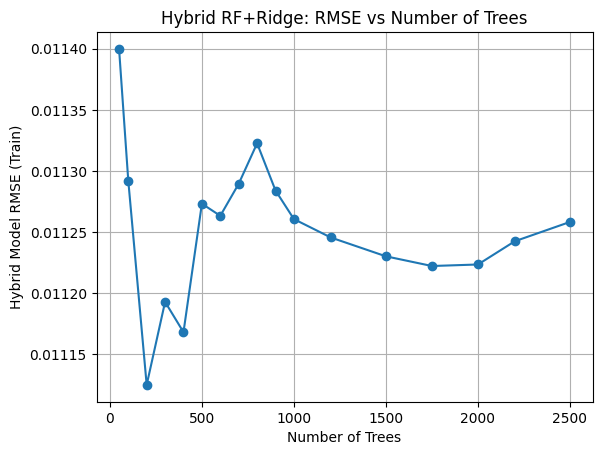

RMSE for different n_estimators: {50: 0.011399822159512928, 100: 0.011292063841926514, 200: 0.011124839903225972, 300: 0.011192803573091877, 400: 0.011168009830803382, 500: 0.011273147844622713, 600: 0.011263237261025304, 700: 0.011289449370894525, 800: 0.011322556331913773, 900: 0.011283946682618872, 1000: 0.011260545397779563, 1200: 0.011245518590141307, 1500: 0.011230084464017487, 1750: 0.01122215495325735, 2000: 0.011223401634391776, 2200: 0.011242407738079316, 2500: 0.011258215627442938}


In [17]:
n_tree_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1750, 2000, 2200, 2500]  #List of n_estimators to evaluate
rmse_scores = []                                                                                             #List to hold RMSE scores

#Preprocess features once
x_train_pre = best_model.named_steps['pre'].transform(x_train)                                               #Preprocess training features

for n in n_tree_list:                                                                                        #Iterate over number of trees
    rf_temp = RandomForestRegressor(                                                                         #  Initialise temporary Random Forest model
        n_estimators      = n,                                                                               #    Number of trees
        max_depth         = 10,                                                                              #    Maximum depth
        min_samples_split = 20,                                                                              #    Minimum samples split
        random_state      = 42,                                                                              #    Random state for reproducibility
        n_jobs            = -1                                                                               #    Use all available cores  
    )                                                                                                        #  End Random Forest initialisation
    rf_temp.fit(x_train_pre, y_train)                                                                        #  Fit temporary RF model

    residuals_train = y_train - rf_temp.predict(x_train_pre)                                                 #  Calculate residuals
    ridge_temp      = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)                                           #  Initialise temporary Ridge model
    ridge_temp.fit(x_train_pre, residuals_train)                                                             #  Fit Ridge model on residuals
    y_train_hybrid  = rf_temp.predict(x_train_pre) + ridge_temp.predict(x_train_pre)                         #  Hybrid predictions on training set
    rmse_scores.append(root_mean_squared_error(y_train, y_train_hybrid))                                     #  Compute and store RMSE score
#                                                                                                            #Next n_estimators iteration

#Plot 
plt.plot(n_tree_list, rmse_scores, marker='o')                                                               #Plot RMSE scores vs. number of trees
plt.xlabel("Number of Trees")                                                                                #Set x-axis label
plt.ylabel("Hybrid Model RMSE (Train)")                                                                      #Set y-axis label
plt.title("Hybrid RF+Ridge: RMSE vs Number of Trees")                                                        #Set plot title
plt.grid(True)                                                                                               #Enable grid
plt.savefig('Hyperparameter_Tuning_Hybrid.png')
plt.show()                                                                                                   #Display plot

print("RMSE for different n_estimators:", dict(zip(n_tree_list, rmse_scores)))                               #Print RMSE scores for different n_estimators

del n_tree_list, rmse_scores, x_train_pre                                                                    #Clean up temporary variables to prevent scope bleed

# -- Stability --

## Weak pH ranges


Error Metrics by pH Range
    pH_Range       MAE      RMSE  Count
0  7.87-7.95  0.026311  0.033796   28.0
1  7.95-8.05  0.017336  0.024419   28.0
2  8.05-8.15  0.011854  0.023220   18.0
3  8.15-8.20  0.034986  0.036395   14.0


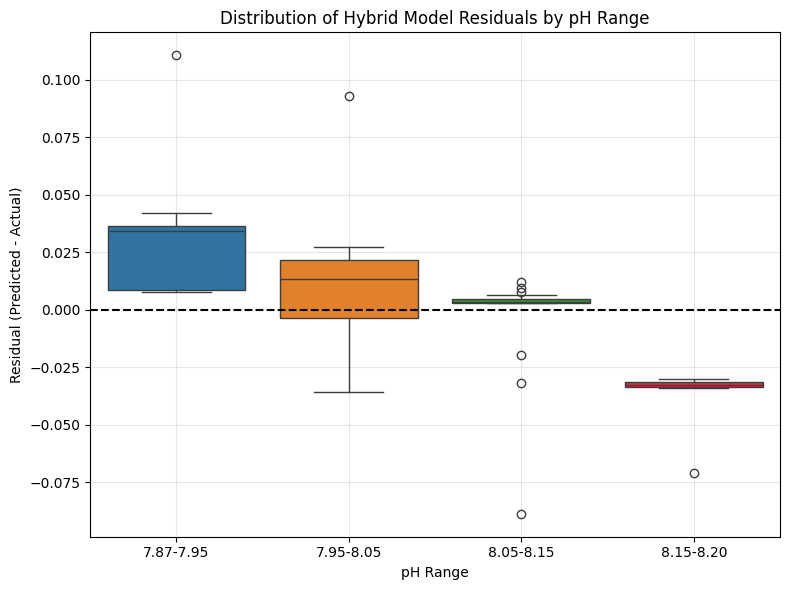

In [18]:
#Define pH bins
bins   = [7.87, 7.95, 8.05, 8.15, 8.20]                                                 #Define pH bins
labels = ['7.87-7.95', '7.95-8.05', '8.05-8.15', '8.15-8.20']                           #Define labels for pH bins

min_len        = min(len(y_test), len(y_test_hybrid))                                   #Determine minimum length; y_test comes from the Hybrid code block
y_test_aligned = y_test.iloc[-min_len:]                                                 #Test aligned to predictions; last min_len entries
y_pred_aligned = y_test_hybrid[-min_len:]                                               #Predictions aligned to test; last min_len entries

y_test_binned = pd.cut(y_test_aligned, bins=bins, labels=labels)                        #Assign bins to aligned test data

results_df = pd.DataFrame({                                                             #Build results DataFrame
                           'Actual_pH'   : y_test_aligned.values,                       #  Actual pH values
                           'Predicted_pH': y_pred_aligned,                              #  Predicted pH values
                           'Residual'    : y_pred_aligned - y_test_aligned.values,      #  Residuals
                           'pH_Range'    : y_test_binned.values                         #  pH range bins
})                                                                                      #End results DataFrame construction

metrics_per_bin = (                                                                     #Define metrics per pH bin
    results_df                                                                          #  Using the results DataFrame
        .groupby('pH_Range', observed=False)[['Actual_pH', 'Predicted_pH']]             #    Group by pH range
        .apply(lambda df: pd.Series({                                                   #    Define lambda function to compute metrics for each bin
            'MAE': mean_absolute_error(df['Actual_pH'], df['Predicted_pH']),            #      Calculate MAE for bin
            'RMSE': np.sqrt(mean_squared_error(df['Actual_pH'], df['Predicted_pH'])),   #      Calculate RMSE for bin
            'Count': len(df)                                                            #      Count of observations in bin
            }))                                                                         #    End lambda function
        .reset_index()                                                                  #  Reset index of metrics DataFrame (to make 'pH_Range' a column)
)                                                                                       #End metrics per bin definition

print("\nError Metrics by pH Range")                                                    #Header for error metrics by pH range
print(metrics_per_bin)                                                                  #Print metrics per pH range

#Plot
plt.figure(figsize=(8, 6))                                                              #Create figure
sns.boxplot(x='pH_Range', y='Residual', data=results_df, hue='pH_Range', legend=False)  #Boxplot of residuals by pH range
plt.axhline(0, color='black', linestyle='--')                                           #Horizontal line at y=0
plt.title('Distribution of Hybrid Model Residuals by pH Range')                         #Plot title
plt.xlabel('pH Range')                                                                  #X-axis label
plt.ylabel('Residual (Predicted - Actual)')                                             #Y-axis label
plt.grid(True, alpha=0.3)                                                               #Enable grid
plt.tight_layout()                                                                      #Adjust layout to prevent clipping
plt.savefig("Hybrid_pH_Residuals.png")                                                  #Save figure
plt.show()                                                                              #Display plotmean_actual_pH    = y_test_aligned.mean()
mean_predicted_pH = y_pred_aligned.mean()

del bins, labels, min_len, y_test_aligned, y_pred_aligned, y_test_binned, results_df, metrics_per_bin  #Clean up temporary variables to prevent scope bleed


## Stability master plot

Skipping models due to missing metrics:
- Random Forest: missing RMSE, tried ['fold_val_rmse_rf']


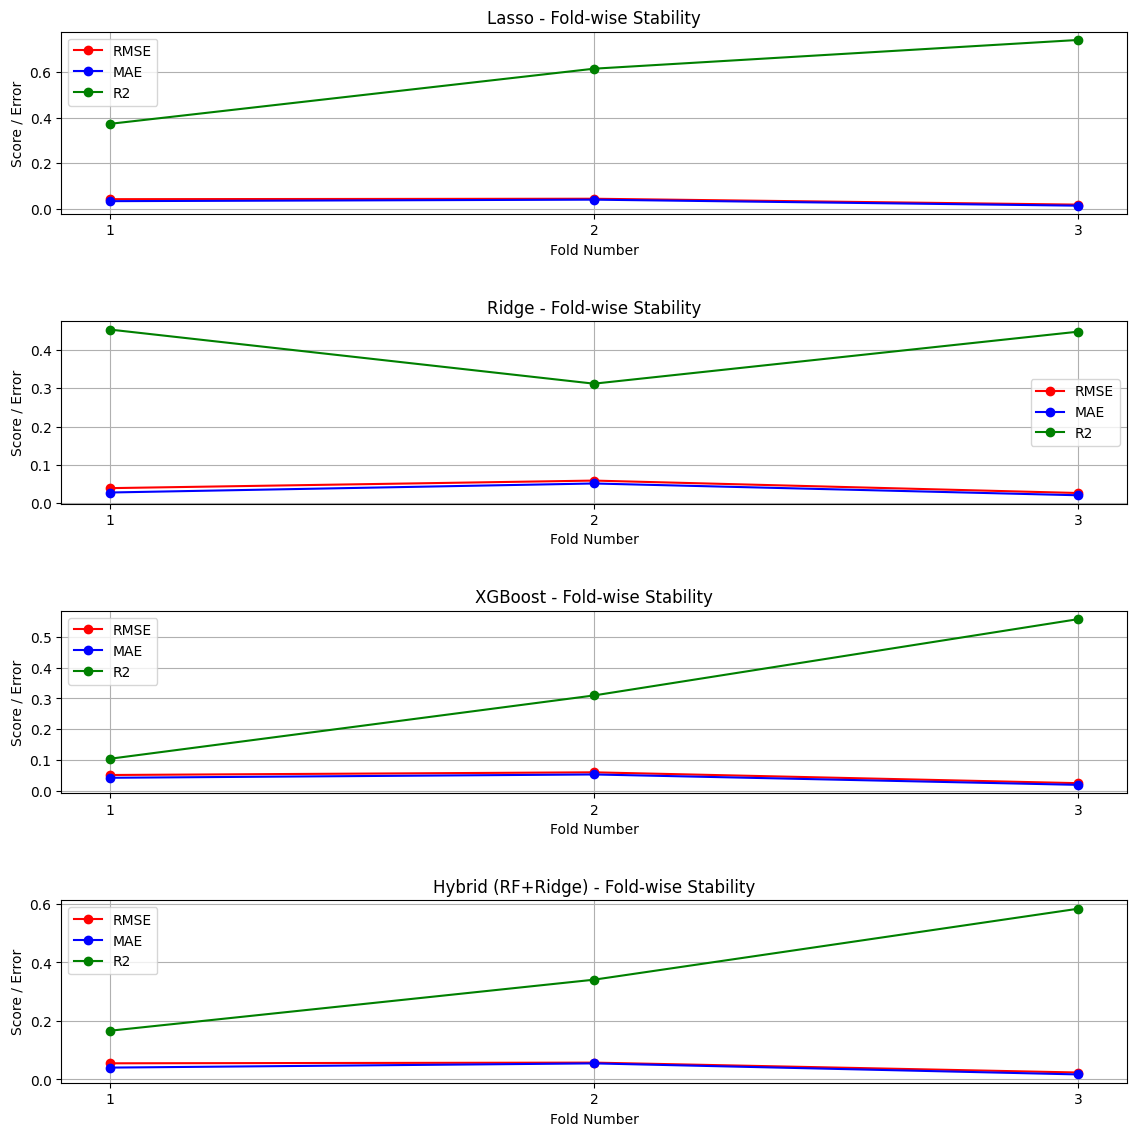

In [19]:
def _resolve_first(candidates):                                                                                      #Return first existing global variable from candidates
    for cand in candidates:                                                                                          #Iterate over candidate names
        if cand in globals():                                                                                        #  If name exists in globals
            return globals()[cand]                                                                                   #    Return its value
        #                                                                                                            #  End name exists check
    #                                                                                                                #Next candidate name iteration
    return None                                                                                                      #No candidate found

model_specs = [                                                                                                      #Candidate metric sources per model
    ("Lasso", {                                                                                                      #  Lasso metrics
        "RMSE": ["fold_rmse_lasso", "fold_rmse"],                                                                    #    Candidate RMSE vars
        "MAE" : ["fold_mae_lasso",  "fold_mae"],                                                                     #    Candidate MAE vars
        "R2"  : ["fold_r2_lasso",   "fold_r2"]                                                                       #    Candidate R2 vars
    }),                                                                                                              #  End Lasso
    ("Ridge", {                                                                                                      #  Ridge metrics
        "RMSE": ["fold_val_rmse_ridge"],                                                                             #    Candidate RMSE vars
        "MAE" : ["fold_val_mae_ridge"],                                                                              #    Candidate MAE vars
        "R2"  : ["fold_val_r2_ridge"]                                                                                #    Candidate R2 vars
    }),                                                                                                              #  End Ridge
    ("XGBoost", {                                                                                                    #  XGBoost metrics (single validation)
        "RMSE": ["xgb_val_rmse"],                                                                                    #    Candidate RMSE vars
        "MAE" : ["xgb_val_mae"],                                                                                     #    Candidate MAE vars
        "R2"  : ["xgb_val_r2"]                                                                                       #    Candidate R2 vars
    }),                                                                                                              #  End XGBoost
    ("Random Forest", {                                                                                              #  Random Forest metrics
        "RMSE": ["fold_val_rmse_rf"],                                                                                #    Candidate RMSE vars
        "MAE" : ["fold_val_mae_rf"],                                                                                 #    Candidate MAE vars
        "R2"  : ["fold_val_r2_rf"]                                                                                   #    Candidate R2 vars
    }),                                                                                                              #  End RF
    ("Hybrid (RF+Ridge)", {                                                                                          #  Hybrid metrics
        "RMSE": ["fold_val_rmse"],                                                                                   #    Candidate RMSE vars
        "MAE" : ["fold_val_mae"],                                                                                    #    Candidate MAE vars
        "R2"  : ["fold_val_r2"]                                                                                      #    Candidate R2 vars
    }),                                                                                                              #  End Hybrid
]                                                                                                                    #End model_specs list

model_metrics = {}                                                                                                   #Collected metrics per model
skipped_models = []                                                                                                  #Track models missing metrics

for model_name, metric_candidates in model_specs:                                                                    #Iterate over model specifications
    metrics = {}                                                                                                     #  Holder for metrics
    for metric_name, candidates in metric_candidates.items():                                                        #  Iterate over each metric
        value = _resolve_first(candidates)                                                                           #    Resolve available metric
        if value is None:                                                                                            #    If missing
            skipped_models.append((model_name, metric_name, candidates))                                             #      Track missing metric
            metrics = None                                                                                           #      Mark as invalid
            break                                                                                                    #      Stop processing this model
        metrics[metric_name] = value                                                                                 #    Store resolved metric
    if metrics:                                                                                                      #  If all metrics resolved
        model_metrics[model_name] = metrics                                                                          #    Add to collection
    #                                                                                                                #  End metrics resolved check
#                                                                                                                    #Next model specification iteration

if not model_metrics:                                                                                                #If no models have metrics
    raise ValueError("No model metrics found; rerun metric cells (Lasso/Ridge/RF/XGBoost/Hybrid) before plotting.")  #  Abort with guidance

if skipped_models:                                                                                                   #If any models skipped
    print("Skipping models due to missing metrics:")                                                                 #  Notify user
    for model_name, metric_name, candidates in skipped_models:                                                       #  Iterate missing entries
        print(f"- {model_name}: missing {metric_name}, tried {candidates}")                                          #    Print detail
    #                                                                                                                #  Next missing entry iteration
#                                                                                                                    #End skipped models check

num_models = len(model_metrics)                                                                                      #Number of models to plot
plt.figure(figsize=(12, 3 * num_models))                                                                             #Create figure with dynamic height

#Colors for metrics
metric_colors = {"RMSE": "red", "MAE": "blue", "R2": "green"}                                                        #Define plot colours for each metric

for i, (model_name, metrics) in enumerate(model_metrics.items(), start=1):                                           #Iterate over models and their metrics
    plt.subplot(num_models, 1, i)                                                                                    #  Create subplot for each model

    for metric_name, color in metric_colors.items():                                                                 #  Iterate over each metric and its color
        values = np.atleast_1d(np.array(metrics[metric_name], dtype=float))                                          #    Ensure array-like metrics
        folds  = np.arange(1, len(values) + 1)                                                                       #    Fold numbers
        plt.plot(folds, values, marker='o', label=metric_name, color=color)                                          #    Plot fold-wise scores
    #                                                                                                                #  Next metric iteration

    plt.title(f"{model_name} - Fold-wise Stability")                                                                 #  Set subplot title
    plt.xlabel("Fold Number")                                                                                        #  Set x-axis label
    plt.ylabel("Score / Error")                                                                                      #  Set y-axis label
    plt.xticks(folds)                                                                                                #  Set x-ticks to fold numbers
    plt.tight_layout(pad=3.0)                                                                                        #  Adjust layout
    plt.grid(True)                                                                                                   #  Enable grid
    plt.legend()                                                                                                     #  Show legend
#                                                                                                                    #Next model iteration

plt.savefig('Fold_Stability.png')
plt.show()                                                                                                           #Display plot

del model_metrics, num_models, metric_colors, model_specs, skipped_models                                            #Clean up temporary variables to prevent scope bleed
del _resolve_first, values, folds, metric_name, metrics, model_name                                                  #Clean up helper and loop vars

# -- Feature Importance Analysis -- 

## Performance Degradation Analysis

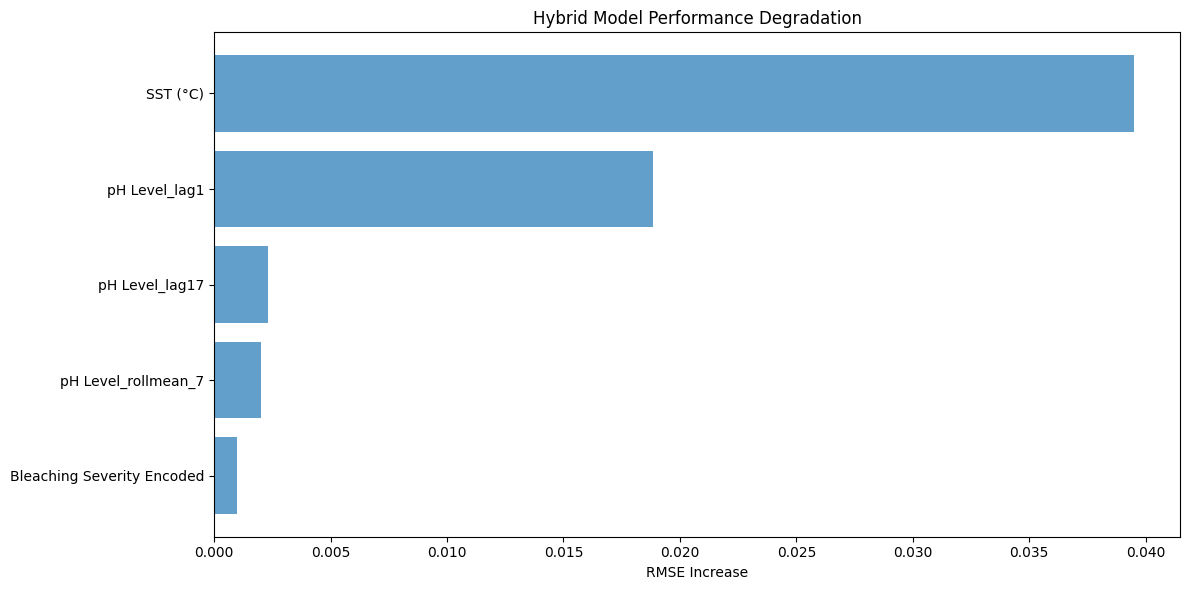

In [20]:
from copy import deepcopy

preprocessor = best_model.named_steps['pre']                                                    #Reuse fitted preprocessing pipeline

rf_pred       = best_model.predict(x_test)                                                      #Predict on test set using RF           `best_model` and `x_test` come from the Hybrid code block
x_test_pre    = preprocessor.transform(x_test)                                                  #Preprocess test features
ridge_pred    = ridge_model.predict(x_test_pre)                                                 #Predict residuals using ridge model    `ridge_model` comes from the Hybrid code block
y_pred_base   = rf_pred + ridge_pred                                                            #Combine RF and ridge predictions
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))                                #Calculate baseline RMSE

#Degradation analysis
degradation_results = []                                                                        #List to hold degradation results

for feature in x_test.columns:                                                                  #Iterate over each feature
    try:                                                                                        #  Try-except to handle potential errors with features
        x_mod = deepcopy(x_test)                                                                #    Deep copy of test features

        if np.issubdtype(x_mod[feature].dtype, np.number):                                      #    Check if feature is numerical
            replacement = x_mod[feature].mean()                                                 #      Use mean for numerical features
        else:                                                                                   #    otherwise (categorical/string feature)
            replacement = x_mod[feature].mode()[0]                                              #      Use mode for categorical features
        #                                                                                       #    End feature type check

        x_drop = x_mod.copy()                                                                   #    Copy of modified features
        x_drop[feature] = replacement                                                           #    Replace feature with its mean/mode

        rf_pred_drop   = best_model.predict(x_drop)                                             #    Predict with RF on modified features
        x_drop_pre     = preprocessor.transform(x_drop)                                         #    Preprocess modified features
        ridge_pred_drop = ridge_model.predict(x_drop_pre)
        y_pred_drop    = rf_pred_drop + ridge_pred_drop                                         #    Combine predictions
        rmse_drop      = np.sqrt(mean_squared_error(y_test, y_pred_drop))                       #    Calculate RMSE after feature drop

        degradation_results.append({                                                            #    Append results
            'Feature'           : feature,                                                      #      Feature name
            'RMSE Increase Drop': rmse_drop - baseline_rmse                                     #      RMSE increase due to feature drop
        })                                                                                      #    End results append

    except Exception as error:                                                                  #  Catch exceptions
        print(f"Error processing {feature}: {error}")                                           #    Print error message
    #                                                                                           #  End feature try-except block
#                                                                                               #Next feature iteration

#Results 
degradation_df = pd.DataFrame(degradation_results)                                              #Create DataFrame from degradation results
degradation_df = degradation_df.sort_values(by='RMSE Increase Drop', ascending=False)           #Sort by RMSE increase

#Plot
top_features = degradation_df.head(5)                                                           #Get top 5 features causing highest RMSE increase
plt.figure(figsize=(12, 6))                                                                     #Create figure
plt.barh(top_features['Feature'], top_features['RMSE Increase Drop'], alpha=0.7)                #Horizontal bar plot
plt.xlabel('RMSE Increase')                                                                     #X-axis label
plt.title('Hybrid Model Performance Degradation')                                               #Set the plot title
plt.gca().invert_yaxis()                                                                        #Invert y-axis to have highest RMSE increase on top
plt.tight_layout()                                                                              #Adjust layout to prevent clipping
plt.savefig('Hybrid_Degradation.png')                                                           #Save figure
plt.show()                                                                                      #Display plot

del preprocessor, rf_pred, x_test_pre, ridge_pred, y_pred_base, baseline_rmse                   #Clean up temporary variables to prevent scope bleed
del degradation_results, degradation_df, top_features                                           #Clean up dataframes/lists

## Permutation Feature Importance


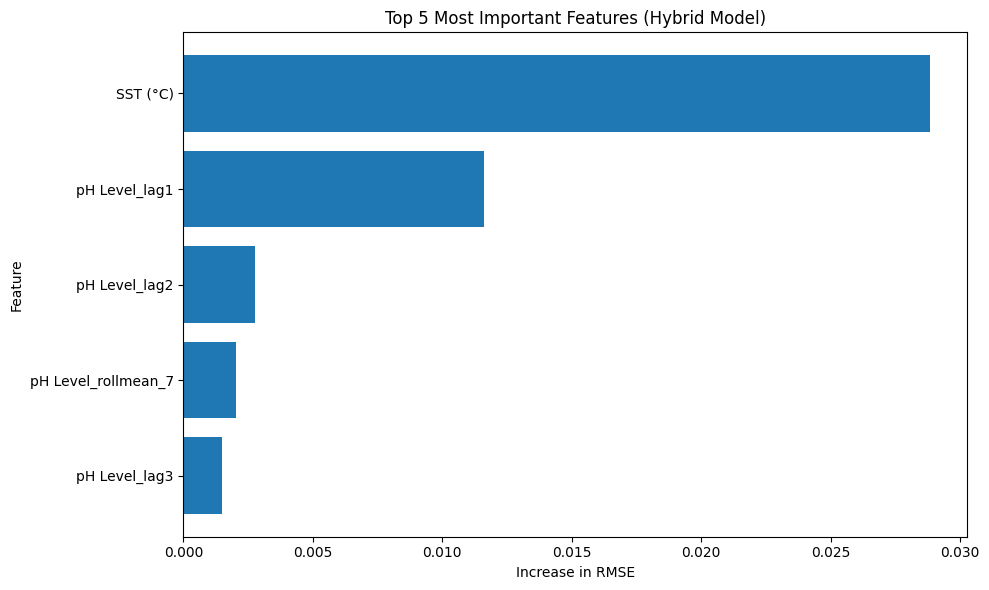

In [21]:
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

numeric_features = [col for col in x_train.columns if pd.api.types.is_numeric_dtype(x_train[col])]                           #Infer numeric features from training set
categorical_features = [col for col in x_train.columns if col not in numeric_features]                                       #Treat remaining columns as categorical

preprocessor = ColumnTransformer(                                                                                            #Preprocessing pipeline
    transformers=[                                                                                                           #  Embedded transformers
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_features),  #    Initialise a numeric transformer
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),                             #    Initialise a categorical transformer
                          ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), categorical_features)   #
    ],                                                                                                                       #  End embedded transformers
    remainder="drop"                                                                                                         #  Drop unused columns
 )                                                                                                                           #End preprocessing pipeline

#Random Forest pipeline
rf_pipeline = Pipeline(steps=[                                                                                               #Random Forest pipeline
    ("pre", preprocessor),                                                                                                   #  Preprocessing
    ("model", RandomForestRegressor(                                                                                         #  Model definition
        n_estimators      = 1000,                                                                                            #    Number of trees
        max_depth         = 10,                                                                                              #    Maximum depth for each tree
        min_samples_split = 20,                                                                                              #    Minimum samples required to split a node
        n_jobs            = -1,                                                                                              #    Use all CPU cores
        random_state      = 42                                                                                               #    Random seed
    ))                                                                                                                       #  End model definition
])                                                                                                                           #End pipeline definition

#Ridge
alphas = np.logspace(-4, 4, 100)                                                                                             #Alpha grid for RidgeCV

ridge_pipeline = Pipeline(steps=[                                                                                            #Ridge pipeline
    ("pre", preprocessor),                                                                                                   #  Preprocessing
    ("model", RidgeCV(alphas=alphas, cv=5))                                                                                  #  RidgeCV model
])                                                                                                                           #End Ridge pipeline

#Hybrid Model
class HybridPermModel(BaseEstimator, RegressorMixin):                                                                        #Hybrid model for permutation importance
    def __init__(self, rf_pipeline=None, ridge_pipeline=None, weight_rf=0.5):                                                #  Initialiser
        self.rf_pipeline  = rf_pipeline                                                                                      #    Random Forest pipeline
        self.ridge_pipeline = ridge_pipeline                                                                                 #    Ridge pipeline
        self.weight_rf    = weight_rf                                                                                        #    RF weight
    #                                                                                                                        #  End Initialiser

    def fit(self, x, y):                                                                                                     #  Fit model
        self.rf_pipeline.fit(x, y)                                                                                           #    Fit RF pipeline
        self.ridge_pipeline.fit(x, y)                                                                                        #    Fit Ridge pipeline
        return self                                                                                                          #    Enable chaining
    #                                                                                                                        #  End Fit

    def predict(self, x):                                                                                                    #  Predict
        rf_pred    = self.rf_pipeline.predict(x)                                                                             #    RF predictions
        ridge_pred = self.ridge_pipeline.predict(x)                                                                          #    Ridge predictions
        return self.weight_rf * rf_pred + (1 - self.weight_rf) * ridge_pred                                                  #    Weighted blend
    #                                                                                                                        #  End Predict

    def get_params(self, deep=True):                                                                                         #  Params accessor
        return {"rf_pipeline": self.rf_pipeline, "ridge_pipeline": self.ridge_pipeline, "weight_rf": self.weight_rf}         #    Return accessor dictionary
    #                                                                                                                        #  End Params accessor

    def set_params(self, **params):                                                                                          #  Params mutator
        for key, value in params.items():                                                                                    #    Iterate over params
            setattr(self, key, value)                                                                                        #      Set attribute
        #                                                                                                                    #    End param iteration
        return self                                                                                                          #    Enable chaining
    #                                                                                                                        #  End Params mutator
#                                                                                                                            #End HybridPermModel definition

hybrid_model = HybridPermModel(                                                                                              #Initialise hybrid model
    rf_pipeline=rf_pipeline,                                                                                                 #  RF pipeline
    ridge_pipeline=ridge_pipeline,                                                                                           #  Ridge pipeline
    weight_rf=0.5                                                                                                            #  RF weight
 )                                                                                                                           #End hybrid model initialisation

hybrid_model.fit(x_train, y_train)                                                                                           #Fit hybrid model

perm_result = permutation_importance(                                                                                        #Permutation importance
    hybrid_model,                                                                                                            #  Hybrid estimator
    x_test,                                                                                                                  #  Test features
    y_test,                                                                                                                  #  Test target
    n_repeats    = 10,                                                                                                       #  Number of repeats
    random_state = 42,                                                                                                       #  Reproducibility
    scoring      = "neg_root_mean_squared_error",                                                                            #  Use RMSE
    n_jobs       = -1                                                                                                        #  Parallel threads
)                                                                                                                            #End permutation importance

importance_df = (                                                                                                            #Importance DataFrame
    pd.DataFrame({                                                                                                           #  Create DataFrame from dictionary
        "Feature"        : x_test.columns,                                                                                   #    Feature names
        "Importance Mean": perm_result.importances_mean,                                                                     #    Mean importance
        "Importance Std" : perm_result.importances_std                                                                       #    Std of importance
    })                                                                                                                       #  End DataFrame creation
    .sort_values("Importance Mean", ascending=False)                                                                         #  Sort by mean importance
)                                                                                                                            #End importance DataFrame definition

top5 = importance_df.head(5).sort_values("Importance Mean", ascending=True)                                                  #Top 5 features for plotting

plt.figure(figsize=(10, 6))                                                                                                  #Create figure
plt.barh(top5["Feature"], top5["Importance Mean"])                                                                           #Horizontal bar plot
plt.xlabel("Increase in RMSE")                                                                                               #X-axis label
plt.ylabel("Feature")                                                                                                        #Y-axis label
plt.title("Top 5 Most Important Features (Hybrid Model)")                                                                    #Plot title
plt.tight_layout()                                                                                                           #Avoid clipping
plt.savefig("Permutation_Feature_Importance.png")                                                                            #Save figure
plt.show()                                                                                                                   #Display plot

del numeric_features, categorical_features, preprocessor, rf_pipeline, alphas, ridge_pipeline, hybrid_model, perm_result, importance_df, top5

## Master Plot

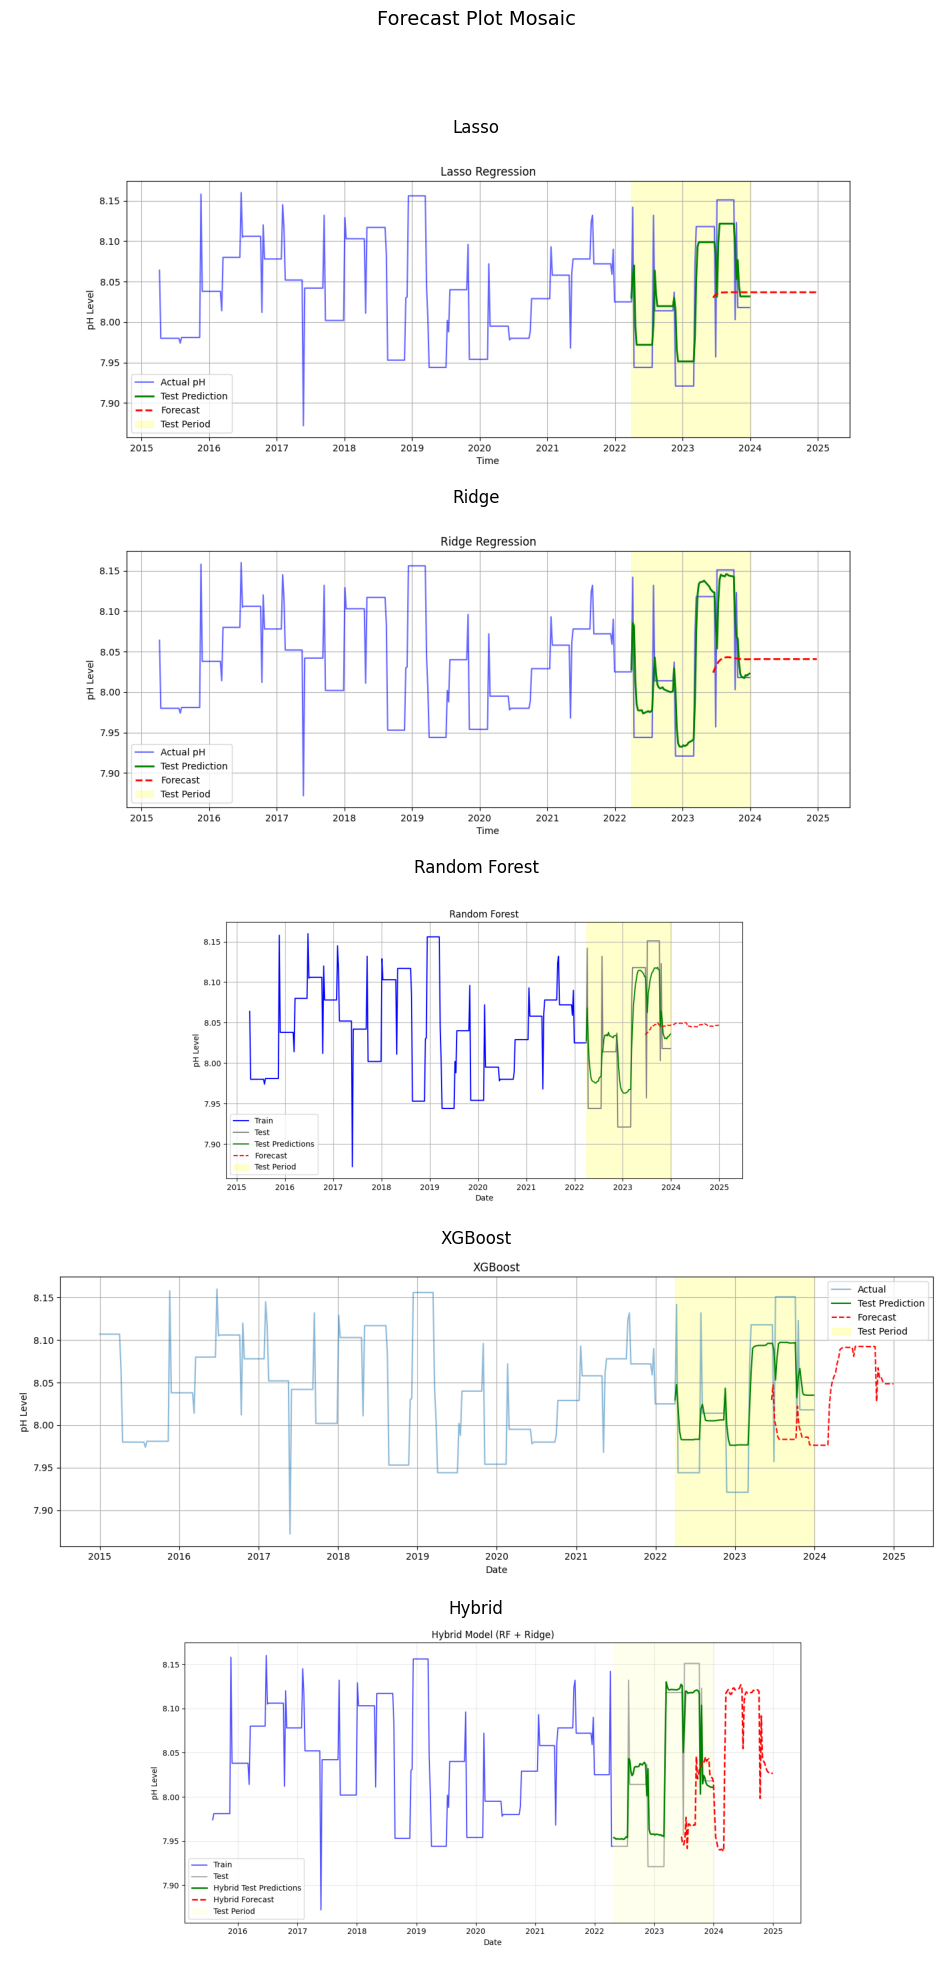

In [22]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_specs = [
    ("Lasso", 'Lasso.png'),
    ("Ridge", 'Ridge.png'),
    ("Random Forest", 'Random_Forest.png'),
    ("XGBoost", 'XGBoost.png'),
    ("Hybrid", 'Hybrid_model.png')
]

available = [(label, path) for label, path in image_specs if os.path.exists(path)]
if not available:
    print('No forecast plot images found on disk; run the model plot cells first.')
else:
    n = len(available)
    rows = 5
    fig, axes = plt.subplots(rows, 1, figsize=(14, 4 * rows))
    axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

    for ax, (label, path) in zip(axes, available):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    for ax in axes[len(available):]:
        ax.axis('off')

    fig.suptitle('Forecast Plot Mosaic', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig('Forecast_Mosaic.png', dpi=150)
    plt.show()